In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
#tf.config.set_visible_devices([], 'GPU')
print(tf.__version__)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_devices))
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ELU, Softmax, LeakyReLU
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Precision
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
#from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

2.2.0
Num GPUs Available:  0


2023-01-15 16:35:04.539011: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-01-15 16:35:04.573988: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-15 16:35:04.573999: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dominykas-MS-7B00): /proc/driver/nvidia/version does not exist


In [3]:
def Y_rebuild(Y, classes):
    Y_mod = pd.DataFrame()
    for i in range(len(classes)):
        Y_mod[classes[i]] = (Y == i)*1
    return Y_mod

def model_fit(model_in, classes, DF, model_loc, model_name, 
              class_weights, train_valid_split=0.7, epochs = 50, verbose = 2): 
    callback_loc = model_loc + model_name + '/'
    model_checkpoint_callback_loss = ModelCheckpoint(filepath=callback_loc + "min_loss",
                                                     save_weights_only=True,
                                                     monitor='val_loss',
                                                     mode='min',
                                                     save_best_only=True)
    model_checkpoint_callback_acc = ModelCheckpoint(filepath=callback_loc + "max_acc",
                                                    save_weights_only=True,
                                                    monitor='val_accuracy',
                                                    mode='max',
                                                    save_best_only=True)
    model_checkpoint_callback_prec = ModelCheckpoint(filepath=callback_loc + "max_prec",
                                                     save_weights_only=True,
                                                     monitor='val_precision',
                                                     mode='max',
                                                     save_best_only=True)
    Y = Y_rebuild(DF['Process'], classes)
    X = DF[DF.columns[2:]]
    split_num = int(X.shape[0]*train_valid_split)
    x_train = X.loc[:split_num-1]
    y_train = Y.loc[:split_num-1]
    x_valid = X.loc[split_num:]
    y_valid = Y.loc[split_num:]
    weights = DF['Weight'].copy()
    for i in range(len(classes)):
        weights[DF['Process'] == i] *= class_weights[i]
    log = model_in.fit(x_train, y_train,
                       callbacks = [model_checkpoint_callback_loss, 
                                    model_checkpoint_callback_acc, 
                                    model_checkpoint_callback_prec],
                       batch_size = 150, 
                       epochs = epochs, 
                       verbose = verbose,
                       sample_weight = weights[:split_num],
                       validation_data = (x_valid, y_valid, weights[split_num:]))
    model_in.save(model_loc + model_name + "_last")
    return (model_in, log.history['accuracy'], log.history['loss'], log.history['precision'],
            log.history['val_accuracy'], log.history['val_loss'], log.history['val_precision'])

def data_read_rescale(data_loc_name, scale=None, limit=None):
    #print("Reading " + data_loc_name)
    DF_init = pd.read_csv(data_loc_name, dtype=np.float32)
    DF = pd.DataFrame(columns=DF_init.columns)
    if limit is None:
        DF = DF_init
        #print(DF.shape, DF_init.shape)
    else:
        new_process_num = 0
        for i in range(len(limit)):
            if limit[i] is None:
                continue
            if limit[i] == 0:
                DF = pd.concat([DF, DF_init.loc[DF_init['Process'] == i]], ignore_index=True)
            else:
                DF = pd.concat([DF, DF_init.loc[DF_init['Process'] == i].reset_index(drop=True).iloc[:limit[i]]], 
                               ignore_index=True)
            DF['Process'].loc[DF['Process'] == i] = new_process_num
            #print(DF['Process'].unique(), i, new_process_num)
            new_process_num += 1
    if scale is None:
        return DF
    else:
        DF[DF.columns[2:6]] = ((DF - scale[0]) / (scale[1] - scale[0]))[DF.columns[2:6]]
        max_pt = np.max(scale[1][6::4])
        min_pt = np.min(scale[0][6::4])
        max_eta = np.max(scale[1][7::4])
        min_eta = np.min(scale[0][7::4])
        max_phi = np.max(scale[1][8::4])
        min_phi = np.min(scale[0][8::4])
        max_E = np.max(scale[1][9::4])
        min_E = np.min(scale[0][9::4])
        for i in range(6, len(DF.columns), 4):
            DF[DF.columns[i+0]].loc[DF[DF.columns[i+0]] != 0] = ((DF[DF.columns[i+0]].loc[DF[DF.columns[i+0]] != 0] - min_pt) / (max_pt - min_pt))
            DF[DF.columns[i+1]].loc[DF[DF.columns[i+1]] != 0] = ((DF[DF.columns[i+1]].loc[DF[DF.columns[i+1]] != 0] - min_eta) / (max_eta - min_eta)) * 2 - 1
            DF[DF.columns[i+2]].loc[DF[DF.columns[i+2]] != 0] = ((DF[DF.columns[i+2]].loc[DF[DF.columns[i+2]] != 0] - min_phi) / (max_phi - min_phi)) * 2 - 1
            DF[DF.columns[i+3]].loc[DF[DF.columns[i+3]] != 0] = ((DF[DF.columns[i+3]].loc[DF[DF.columns[i+3]] != 0] - min_E) / (max_E - min_E))
        return DF

def print_conf_matrix(y_true, y_pred, labels, ax, title, weights=None):
    if weights is None:
        weights = [np.full(len(y_true), 1.)]
    f_title = f'{title} (acc = {accuracy_score(y_true, y_pred, sample_weight=weights[0]):.3f})'
    if len(weights) == 2:
        f_title += f'(w_acc = {accuracy_score(y_true, y_pred, sample_weight=weights[1]):.3f})'
    disp = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrix(y_true, y_pred, sample_weight=weights[0], normalize='true', 
                                            labels=range(len(labels))), display_labels = labels)
    disp.plot(include_values = True, cmap = plt.cm.Blues, ax = ax)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    ax.set_title(f_title)
    ax.set_xlabel("Modelio spėjimas")
    ax.set_ylabel("Tikroji klasė", rotation='vertical')

def draw_res(res_model, model_loc, model_name, DF_test):
    model_in = res_model[0]
    train_hist_acc = res_model[1]
    train_hist_loss = res_model[2]
    train_hist_prec = res_model[3]
    valid_hist_acc = res_model[4]
    valid_hist_loss = res_model[5]
    valid_hist_prec = res_model[6]
    X = DF_test[DF_test.columns[2:]]
    counts, ranges = np.histogram(DF_test['Process'], bins=range(len(legend_names) + 1), 
                                  weights=DF_test['Weight'])
    c_weights = max(counts)/counts
    balanced_weights = DF_test['Weight'].copy()
    for i in range(len(legend_names)):
        balanced_weights[DF_test['Process'] == i] *= c_weights[i]
    
    
    model_in.load_weights(model_loc + model_name + "/min_loss")
    fig_cm_loss, axs_cm_loss = plt.subplots(1, 1, figsize=(7, 7))
    print_conf_matrix(DF_test['Process'], np.argmax(model_in.predict(X), axis=-1), 
                      legend_names, axs_cm_loss, 'Testavimo aibė', weights=[DF_test['Weight'], balanced_weights])
    fig_cm_loss.savefig(model_loc + model_name + "/min_loss.pdf", bbox_inches="tight", pad_inches=0.15)
    
    
    
    model_in.load_weights(model_loc + model_name + "/max_acc")
    fig_cm_acc, axs_cm_acc = plt.subplots(1, 1, figsize=(7, 7))
    print_conf_matrix(DF_test['Process'], np.argmax(model_in.predict(X), axis=-1), 
                      legend_names, axs_cm_acc, 'Testavimo aibė', weights=[DF_test['Weight'], balanced_weights])
    fig_cm_acc.savefig(model_loc + model_name + "/max_acc.pdf", bbox_inches="tight", pad_inches=0.15)
    
    
    
    model_in.load_weights(model_loc + model_name + "/max_prec")
    fig_cm_prec, axs_cm_prec = plt.subplots(1, 1, figsize=(7, 7))
    print_conf_matrix(DF_test['Process'], np.argmax(model_in.predict(X), axis=-1), 
                      legend_names, axs_cm_prec, 'Testavimo aibė', weights=[DF_test['Weight'], balanced_weights])
    fig_cm_prec.savefig(model_loc + model_name + "/max_prec.pdf", bbox_inches="tight", pad_inches=0.15)
    
    
    
    xepochs = range(1, len(train_hist_loss) + 1)
    
    fig_log_loss, axs_log_loss = plt.subplots(1, 1, dpi=200, figsize=(7, 7))
    axs_log_loss.set_xlabel("Mokymosi epochos")
    axs_log_loss.set_ylabel("Prarastis")
    axs_log_loss.plot(xepochs, train_hist_loss, label = 'Mokymosi aibė')
    axs_log_loss.plot(xepochs, valid_hist_loss, label = 'Validacijos aibė')
    axs_log_loss.legend()
    fig_log_loss.savefig(model_loc + model_name + "/log_loss.pdf", bbox_inches="tight", pad_inches=0.15)
    
    fig_log_acc, axs_log_acc = plt.subplots(1, 1, dpi=200, figsize=(7, 7))
    axs_log_acc.set_xlabel("Mokymosi epochos")
    axs_log_acc.set_ylabel("Tisklumas")
    axs_log_acc.plot(xepochs, train_hist_acc, label = 'Mokymosi aibė')
    axs_log_acc.plot(xepochs, valid_hist_acc, label = 'Validacijos aibė')
    axs_log_acc.legend()
    fig_log_loss.savefig(model_loc + model_name + "/log_acc.pdf", bbox_inches="tight", pad_inches=0.15)
    
    fig_log_prec, axs_log_prec = plt.subplots(1, 1, dpi=200, figsize=(7, 7))
    axs_log_prec.set_xlabel("Mokymosi epochos")
    axs_log_prec.set_ylabel("Preciziškumas")
    axs_log_prec.plot(xepochs, train_hist_prec, label = 'Mokymosi aibė')
    axs_log_prec.plot(xepochs, valid_hist_prec, label = 'Validacijos aibė')
    axs_log_prec.legend()
    fig_log_loss.savefig(model_loc + model_name + "/log_prec.pdf", bbox_inches="tight", pad_inches=0.15)
    
def full_calc_draw(model_in, classes, DF, model_loc, model_name, class_weights, DF_test,
                   train_valid_split=0.7, epochs = 50):
    res = model_fit(model_in, classes, DF, model_loc, model_name, class_weights, 
                    train_valid_split=0.7, epochs = 50)
    draw_res(res, model_loc, model_name, DF_test)
    return res

In [4]:
def iteration(model_loc, DF_train, DF_test, Ac_func, Ac_name, Ac_const, test_size, 
              classes, test_name, iter_num, hist_train, weights_test, 
              epochs = 30, verbose = 2):
    res_hist = np.empty((6, epochs))
    param_test_res = np.empty((3, 2))
    iter_name = test_name + "_iter_" + str(iter_num)
    print(iter_name)
    test_model = Sequential(name=iter_name)
    test_model.add(Dense(DF_train.shape[1] - 2, activation = Ac_func(Ac_const), name = 'Input', 
                         input_dim = DF_train.shape[1] - 2))
    for j in range(test_size[0]):
        test_model.add(Dense(test_size[1], activation = Ac_func(Ac_const), name = Ac_name + str(j)))
    test_model.add(BatchNormalization())
    test_model.add(Dense(len(legend_names), name = 'Output'))
    test_model.add(Softmax())
    test_model.compile(loss = CategoricalCrossentropy(), optimizer = Adam(), 
                       weighted_metrics = ['accuracy', Precision(name='precision')])
    res = model_fit(test_model, legend_names, DF_train, model_loc, 
                    test_name + "/iter" + str(iter_num), max(hist_train)/hist_train, epochs=epochs, verbose=verbose)
        
    test_model = res[0]
    res_hist = res[1:]
        
    test_model.load_weights(model_loc + test_name + "/iter" + str(iter_num) + "/min_loss")
    param_test_res[0][0] = accuracy_score(DF_test['Process'], 
                                          np.argmax(test_model.predict(X), axis=-1), 
                                          sample_weight=DF_test['Weight'])
    param_test_res[0][1] = accuracy_score(DF_test['Process'], 
                                          np.argmax(test_model.predict(X), axis=-1), 
                                          sample_weight=weights_test)
    test_model.load_weights(model_loc + test_name + "/iter" + str(iter_num) + "/max_acc")
    param_test_res[1][0] = accuracy_score(DF_test['Process'], 
                                          np.argmax(test_model.predict(X), axis=-1), 
                                          sample_weight=DF_test['Weight'])
    param_test_res[1][1] = accuracy_score(DF_test['Process'], 
                                          np.argmax(test_model.predict(X), axis=-1), 
                                          sample_weight=weights_test)
    test_model.load_weights(model_loc + test_name + "/iter" + str(iter_num) + "/max_prec")
    param_test_res[2][0] = accuracy_score(DF_test['Process'], 
                                          np.argmax(test_model.predict(X), axis=-1), 
                                          sample_weight=DF_test['Weight'])
    param_test_res[2][1] = accuracy_score(DF_test['Process'], 
                                          np.argmax(test_model.predict(X), axis=-1), 
                                          sample_weight=weights_test)
    return param_test_res, res_hist


def scanner(model_loc, DF_train, DF_test, Activation, Activation_name, Activation_const, size, 
            classes, iterations = 3, epochs = 40):
    X = DF_test[DF_test.columns[2:]]
    weights_test = DF_test['Weight'].copy()
    hist_test, ranges = np.histogram(DF_test['Process'], bins=range(10), weights=DF_test['Weight'])
    class_weights_test = max(hist_test)/hist_test
    for i in range(len(classes)):
        weights_test[DF_test['Process'] == i] *= class_weights_test[i]
    hist_train, ranges = np.histogram(DF_train['Process'], bins=range(10), weights=DF_train['Weight'])
    
    
    if len(Activation) > 1:
        res_hist = np.empty((len(Activation), iterations, 6, epochs))
        param_test_res = np.empty((len(Activation), iterations, 3, 2))
        test_size = size[0]
        for j, Ac_func in enumerate(Activation):
            Ac_name = Activation_name[j]
            Ac_const = Activation_const[j]
            test_name = (Ac_name + "_" + str(Ac_const) + "_size_" + str(test_size[0]) + "_" + str(test_size[1]))
            for i in range(iterations):
                param_test_res[j][i], res_hist[j][i] = iteration(model_loc, DF_train, DF_test, 
                                                                 Ac_func, Ac_name, Ac_const, test_size, 
                                                                 classes, test_name, i, hist_train, weights_test, 
                                                                 epochs = epochs)
        return param_test_res, res_hist
    
    if len(Activation_const) > 1:
        Ac_func = Activation[0]
        Ac_name = Activation_name[0]
        test_size = size[0]
        res_hist = np.empty((len(Activation_const), iterations, 6, epochs))
        param_test_res = np.empty((len(Activation_const), iterations, 3, 2))
        for j, Ac_const in enumerate(Activation_const):
            test_name = (Ac_name + "_" + str(Ac_const) + "_size_" + str(test_size[0]) + "_" + str(test_size[1]))
            for i in range(iterations):
                param_test_res[j][i], res_hist[j][i] = iteration(model_loc, DF_train, DF_test, 
                                                                 Ac_func, Ac_name, Ac_const, test_size, 
                                                                 classes, test_name, i, hist_train, weights_test,
                                                                 epochs = epochs)
        return param_test_res, res_hist
    
    if len(size) > 1:
        Ac_func = Activation[0]
        Ac_name = Activation_name[0]
        Ac_const = Activation_const[0]
        res_hist = np.empty((len(size), iterations, 6, epochs))
        param_test_res = np.empty((len(size), iterations, 3, 2))
        for j, test_size in enumerate(size):
            test_name = (Ac_name + "_" + str(Ac_const) + "_size_" + str(test_size[0]) + "_" + str(test_size[1]))
            for i in range(iterations):
                param_test_res[j][i], res_hist[j][i] = iteration(model_loc, DF_train, DF_test, 
                                                                 Ac_func, Ac_name, Ac_const, test_size, 
                                                                 classes, test_name, i, hist_train, weights_test,
                                                                 epochs = epochs)
        return param_test_res, res_hist
    

In [18]:
def label_setup(Activation_name, Activation_const, size):
    name = ""
    if len(Activation_name) > 1:
        labels = [""] * len(Activation_name)
        for i in range(len(Activation_name)):
            labels[i] = Activation_name[i] + f"({Activation_const[i]})"
            name += Activation_name[i] + f"_{Activation_const[i]}_" 
        name += f'{size[0][0]}_' + f"{size[0][1]}"
        return labels, name
    if len(Activation_const) > 1:
        labels = [""] * len(Activation_const)
        for i in range(len(Activation_const)):
            labels[i] = Activation_name[0] + f"({Activation_const[i]})"
            name += Activation_name[0] + f"_{Activation_const[i]}_" 
        name += f'{size[0][0]}_' + f"{size[0][1]}"
        return labels, name
    if len(size) > 1:
        labels = [""] * len(size)
        for i in range(len(size)):
            labels[i] = f'({size[i][0]}, {size[i][1]})'
            name += f'{size[i][0]}_{size[i][1]}_' 
        name += Activation_name[0] + "_" + f"_{Activation_const[0]}"
        return labels, name

def scanner_graph(model_loc, history, Activation_name, Activation_const, size): 
    xepochs = range(1, len(history[0][0][0]) + 1)
    labels, name = label_setup(Activation_name, Activation_const, size)
    np.save(model_loc + name, history)
    color = ['r', 'g', 'b']
    
    fig_log_loss, axs_log_loss = plt.subplots(1, 1, dpi=200, figsize=(7, 7))
    axs_log_loss.set_xlabel("Mokymosi epochos")
    axs_log_loss.set_ylabel("Prarastis")
    for i in range(len(labels)):
        axs_log_loss.plot(xepochs, np.average(history, axis=1)[i][1], label = 'Mokymosi aibė - ' + labels[i], 
                          c=color[i], linestyle='dashed')
        axs_log_loss.plot(xepochs, np.average(history, axis=1)[i][4], label = 'Validacijos aibė - ' + labels[i], 
                          c=color[i])
    if np.min(history[:, :, 1]) < 0:
        axs_log_loss.set_ylim(0, None)
    axs_log_loss.legend()
    fig_log_loss.savefig(model_loc + "log_loss_" + name + ".pdf", bbox_inches="tight", pad_inches=0.15)
    
    
    fig_log_acc, axs_log_acc = plt.subplots(1, 1, dpi=200, figsize=(7, 7))
    axs_log_acc.set_xlabel("Mokymosi epochos")
    axs_log_acc.set_ylabel("Tisklumas")
    for i in range(len(labels)):
        axs_log_acc.plot(xepochs, np.average(history, axis=1)[i][0], label = 'Mokymosi aibė - ' + labels[i], 
                          c=color[i], linestyle='dashed')
        axs_log_acc.plot(xepochs, np.average(history, axis=1)[i][3], label = 'Validacijos aibė - ' + labels[i], 
                          c=color[i])
    axs_log_acc.legend()
    fig_log_acc.savefig(model_loc + "log_acc_" + name + ".pdf", bbox_inches="tight", pad_inches=0.15)
    

    fig_log_prec, axs_log_prec = plt.subplots(1, 1, dpi=200, figsize=(7, 7))
    axs_log_prec.set_xlabel("Mokymosi epochos")
    axs_log_prec.set_ylabel("Preciziškumas")
    for i in range(len(labels)):
        axs_log_prec.plot(xepochs, np.average(history, axis=1)[i][2], label = 'Mokymosi aibė - ' + labels[i], 
                          c=color[i], linestyle='dashed')
        axs_log_prec.plot(xepochs, np.average(history, axis=1)[i][5], label = 'Validacijos aibė - ' + labels[i], 
                          c=color[i])
    axs_log_prec.legend()
    fig_log_acc.savefig(model_loc + "log_prec_" + name + ".pdf", bbox_inches="tight", pad_inches=0.15)

In [6]:
data_loc = "/home/dominykas/dy_mas_do/MuMu/"
data_name = "MC_data_"
legend_names = ["$QCD$", "$W + Jets$", "$WW$", "$WZ$", "$ZZ$", "$\\bar{t}W$", "$tW$", "$t\\bar{t}$", 
                "$Drell Yan \\rightarrow \\tau\\tau$", "$Drell Yan \\rightarrow \\mu\\mu$"]
legend_names = legend_names[1:]
Min_Max = pd.read_csv(data_loc + data_name + "min_max.csv")
X_width = len(Min_Max.columns) - 2
Min_Max.T

0             1
Process     0.000000e+00  9.000000e+00
Weight     -1.213690e+01  2.025310e+03
Phot_count  0.000000e+00  9.000000e+00
InvM        0.000000e+00  1.145740e+04
MET_pT     -2.147480e+09  1.610610e+09
MET_phi    -2.147480e+09  2.147480e+09
pT_l1       0.000000e+00  3.055180e+04
eta_l1     -2.400000e+00  2.400000e+00
phi_l1     -3.141590e+00  3.141590e+00
E_l1        0.000000e+00  1.512200e+05
pT_l2       0.000000e+00  1.175280e+04
eta_l2     -2.400000e+00  2.400000e+00
phi_l2     -3.141590e+00  3.141590e+00
E_l2        0.000000e+00  2.716170e+04
pT_p0       0.000000e+00  4.356050e+03
eta_p0     -2.988760e+00  2.993970e+00
phi_p0     -3.141590e+00  3.141590e+00
E_p0        0.000000e+00  5.698540e+03
pT_p1       0.000000e+00  1.044100e+03
eta_p1     -2.974560e+00  2.978560e+00
phi_p1     -3.141570e+00  3.141590e+00
E_p1        0.000000e+00  2.737400e+03
pT_p2       0.000000e+00  2.679340e+02
eta_p2     -2.963530e+00  2.973900e+00
phi_p2     -3.141590e+00  3.141420e+00
E_p2        0.000000e+00  8.317200e+02
pT_p3       0.000000e+00  1.384830e+02
eta_p3     -2.949690e+00  2.945450e+00
phi_p3     -3.141410e+00  3.141540e+00
E_p3        0.000000e+00  6.037510e+02
pT_p4       0.000000e+00  7.799420e+01
eta_p4     -2.918440e+00  2.940650e+00
phi_p4     -3.133370e+00  3.140410e+00
E_p4        0.000000e+00  3.058210e+02
pT_p5       0.000000e+00  3.969430e+01
eta_p5     -2.895730e+00  2.944330e+00
phi_p5     -3.140780e+00  3.120670e+00
E_p5        0.000000e+00  2.067360e+02
pT_p6       0.000000e+00  3.520470e+01
eta_p6     -2.725260e+00  2.870970e+00
phi_p6     -3.123810e+00  3.047270e+00
E_p6        0.000000e+00  1.934630e+02
pT_p7       0.000000e+00  3.147250e+01
eta_p7     -1.471850e+00  2.325520e+00
phi_p7     -3.013800e+00  2.853230e+00
E_p7        0.000000e+00  1.202850e+02
pT_p8       0.000000e+00  1.442750e+01
eta_p8     -6.002650e-01  2.496960e+00
phi_p8     -9.824030e-01  3.983410e-01
E_p8        0.000000e+00  7.372840e+01

In [7]:
DF_train = pd.read_csv(data_loc + data_name + "reduced.csv")
hist, ranges = np.histogram(DF_train['Process'], bins=range(10), weights=DF_train['Weight'])
DF_train

Process    Weight  Phot_count      InvM        MET_pT   MET_phi  \
0            6.0  0.065925    0.222222  0.014841 -1.702993e-08  0.367444   
1            6.0  0.131483    0.000000  0.026336  2.857143e-01  0.050636   
2            6.0  0.172204    0.111111  0.004107 -1.702993e-08  0.846273   
3            6.0  0.074658    0.111111  0.008218  5.714286e-01  0.248147   
4            6.0  0.226811    0.111111  0.010367  1.000000e+00  0.290745   
...          ...       ...         ...       ...           ...       ...   
1457046      5.0  0.195038    0.000000  0.007919  2.857143e-01  0.524497   
1457047      2.0  0.789492    0.000000  0.007624  7.142860e-01  0.093985   
1457048      6.0  0.171132    0.111111  0.004482  8.571429e-01  0.670943   
1457049      6.0  0.195326    0.000000  0.001632  8.571429e-01  0.940530   
1457050      6.0  0.072256    0.111111  0.011322  8.571429e-01  0.796638   

            pT_l1    eta_l1    phi_l1      E_l1  ...  phi_p6  E_p6  pT_p7  \
0        0.002449 -0.228509  0.721666  0.000614  ...     0.0   0.0    0.0   
1        0.002660 -0.744645 -0.982442  0.002516  ...     0.0   0.0    0.0   
2        0.001059  0.077437  0.793149  0.000220  ...     0.0   0.0    0.0   
3        0.002609 -0.665490  0.607075  0.001960  ...     0.0   0.0    0.0   
4        0.002186  0.025362 -0.792092  0.000443  ...     0.0   0.0    0.0   
...           ...       ...       ...       ...  ...     ...   ...    ...   
1457046  0.004241  0.206002  0.716128  0.001026  ...     0.0   0.0    0.0   
1457047  0.001809  0.467781  0.750333  0.000787  ...     0.0   0.0    0.0   
1457048  0.001452 -0.354291 -0.770556  0.000473  ...     0.0   0.0    0.0   
1457049  0.001445 -0.013043 -0.057670  0.000292  ...     0.0   0.0    0.0   
1457050  0.002826  0.297826 -0.681563  0.000815  ...     0.0   0.0    0.0   

         eta_p7  phi_p7  E_p7  pT_p8  eta_p8  phi_p8  E_p8  
0           0.0     0.0   0.0    0.0     0.0     0.0   0.0  
1           0.0     0.0   0.0    0.0     0.0     0.0   0.0  
2           0.0     0.0   0.0    0.0     0.0     0.0   0.0  
3           0.0     0.0   0.0    0.0     0.0     0.0   0.0  
4           0.0     0.0   0.0    0.0     0.0     0.0   0.0  
...         ...     ...   ...    ...     ...     ...   ...  
1457046     0.0     0.0   0.0    0.0     0.0     0.0   0.0  
1457047     0.0     0.0   0.0    0.0     0.0     0.0   0.0  
1457048     0.0     0.0   0.0    0.0     0.0     0.0   0.0  
1457049     0.0     0.0   0.0    0.0     0.0     0.0   0.0  
1457050     0.0     0.0   0.0    0.0     0.0     0.0   0.0  

[1457051 rows x 50 columns]

In [8]:
DF_test = data_read_rescale(data_loc + data_name + str(16) + ".csv", scale=Min_Max.T, 
                            limit=[None, 0, 0, 0, 0, 0, 0, 0, 0, 0])
X = DF_test[DF_test.columns[2:]]

/home/dominykas/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
model_w1 = Sequential(name="Classifier1_w1")
model_w1.add(Dense(X_width, input_dim = X_width, activation = ELU(1), name = 'Input'))
model_w1.add(Dense(X_width, activation = ELU(1), name = 'ELU1'))
model_w1.add(Dense(X_width, activation = ELU(1), name = 'ELU2'))
model_w1.add(Dense(X_width, activation = ELU(1), name = 'ELU3'))
model_w1.add(Dense(X_width, activation = ELU(1), name = 'ELU4'))
model_w1.add(Dense(X_width, activation = ELU(1), name = 'ELU5'))
model_w1.add(BatchNormalization())
model_w1.add(Dense(len(legend_names), name = 'Output'))
model_w1.add(Softmax())
model_w1.compile(loss = CategoricalCrossentropy(), optimizer = Adam(), 
                 weighted_metrics = ['accuracy', Precision(name='precision')])
model_w1.summary()

2023-01-15 16:35:09.209584: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2023-01-15 16:35:09.242444: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3692975000 Hz
2023-01-15 16:35:09.242950: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f4f65f2f10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-01-15 16:35:09.242962: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "Classifier1_w1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 48)                2352      
_________________________________________________________________
ELU1 (Dense)                 (None, 48)                2352      
_________________________________________________________________
ELU2 (Dense)                 (None, 48)                2352      
_________________________________________________________________
ELU3 (Dense)                 (None, 48)                2352      
_________________________________________________________________
ELU4 (Dense)                 (None, 48)                2352      
_________________________________________________________________
ELU5 (Dense)                 (None, 48)                2352      
_________________________________________________________________
batch_normalization (BatchNo (None, 48)             

In [10]:
res_model_w1 = model_fit(model_w1, legend_names, DF_train, data_loc, "model_w1", max(hist)/hist)

Epoch 1/50
6800/6800 - 12s - loss: 2.2659 - accuracy: 0.1460 - precision: 0.1968 - val_loss: 2.1870 - val_accuracy: 0.1177 - val_precision: 0.0000e+00
Epoch 2/50
6800/6800 - 13s - loss: 2.2064 - accuracy: 0.1724 - precision: 0.2392 - val_loss: 2.0986 - val_accuracy: 0.2083 - val_precision: 33.6359
Epoch 3/50
6800/6800 - 13s - loss: 2.1479 - accuracy: 0.1994 - precision: 0.3384 - val_loss: 2.0074 - val_accuracy: 0.2401 - val_precision: 0.9189
Epoch 4/50
6800/6800 - 13s - loss: 2.0989 - accuracy: 0.2242 - precision: 0.3389 - val_loss: 2.3608 - val_accuracy: 0.1695 - val_precision: 0.2687
Epoch 5/50
6800/6800 - 13s - loss: 2.0567 - accuracy: 0.2405 - precision: 0.3066 - val_loss: 1.9831 - val_accuracy: 0.2612 - val_precision: 0.4651
Epoch 6/50
6800/6800 - 13s - loss: 2.0361 - accuracy: 0.2467 - precision: 0.3741 - val_loss: 1.9507 - val_accuracy: 0.2800 - val_precision: 0.5552
Epoch 7/50
6800/6800 - 13s - loss: 2.0004 - accuracy: 0.2679 - precision: 0.4199 - val_loss: 1.9641 - val_accurac

2023-01-15 16:46:06.916501: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/dominykas/dy_mas_do/MuMu/model_w1_last/assets


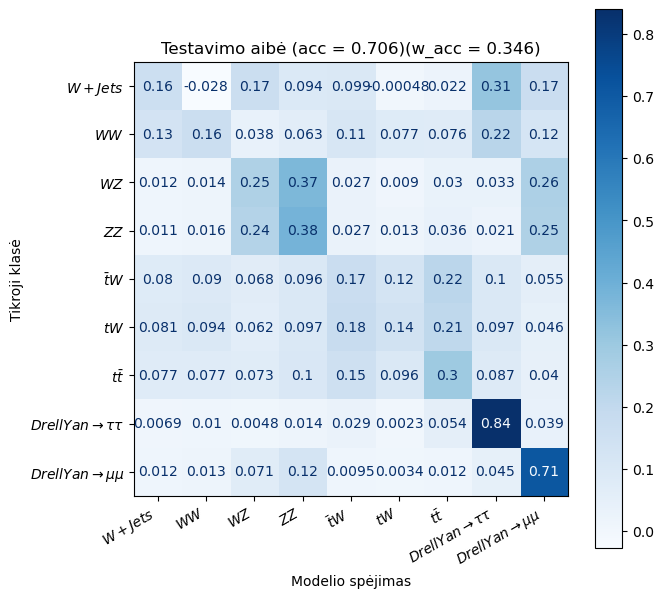

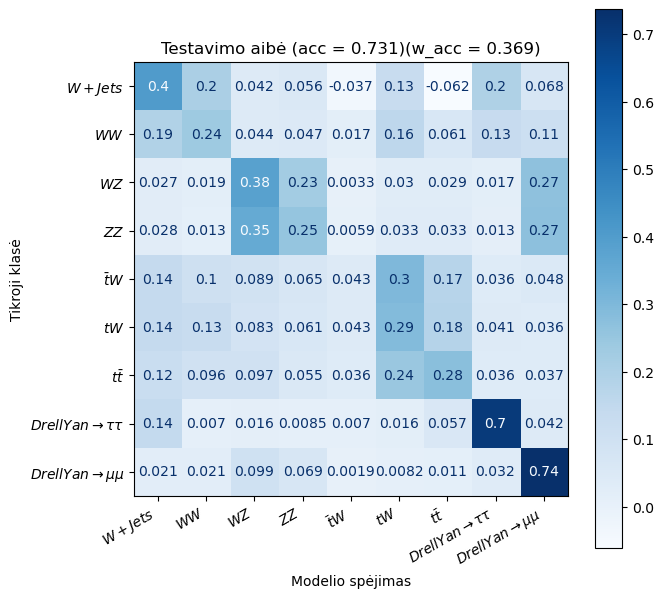

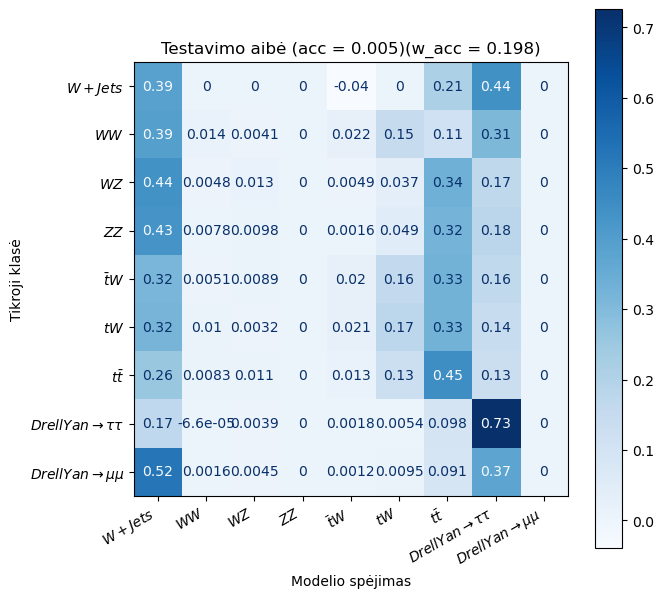

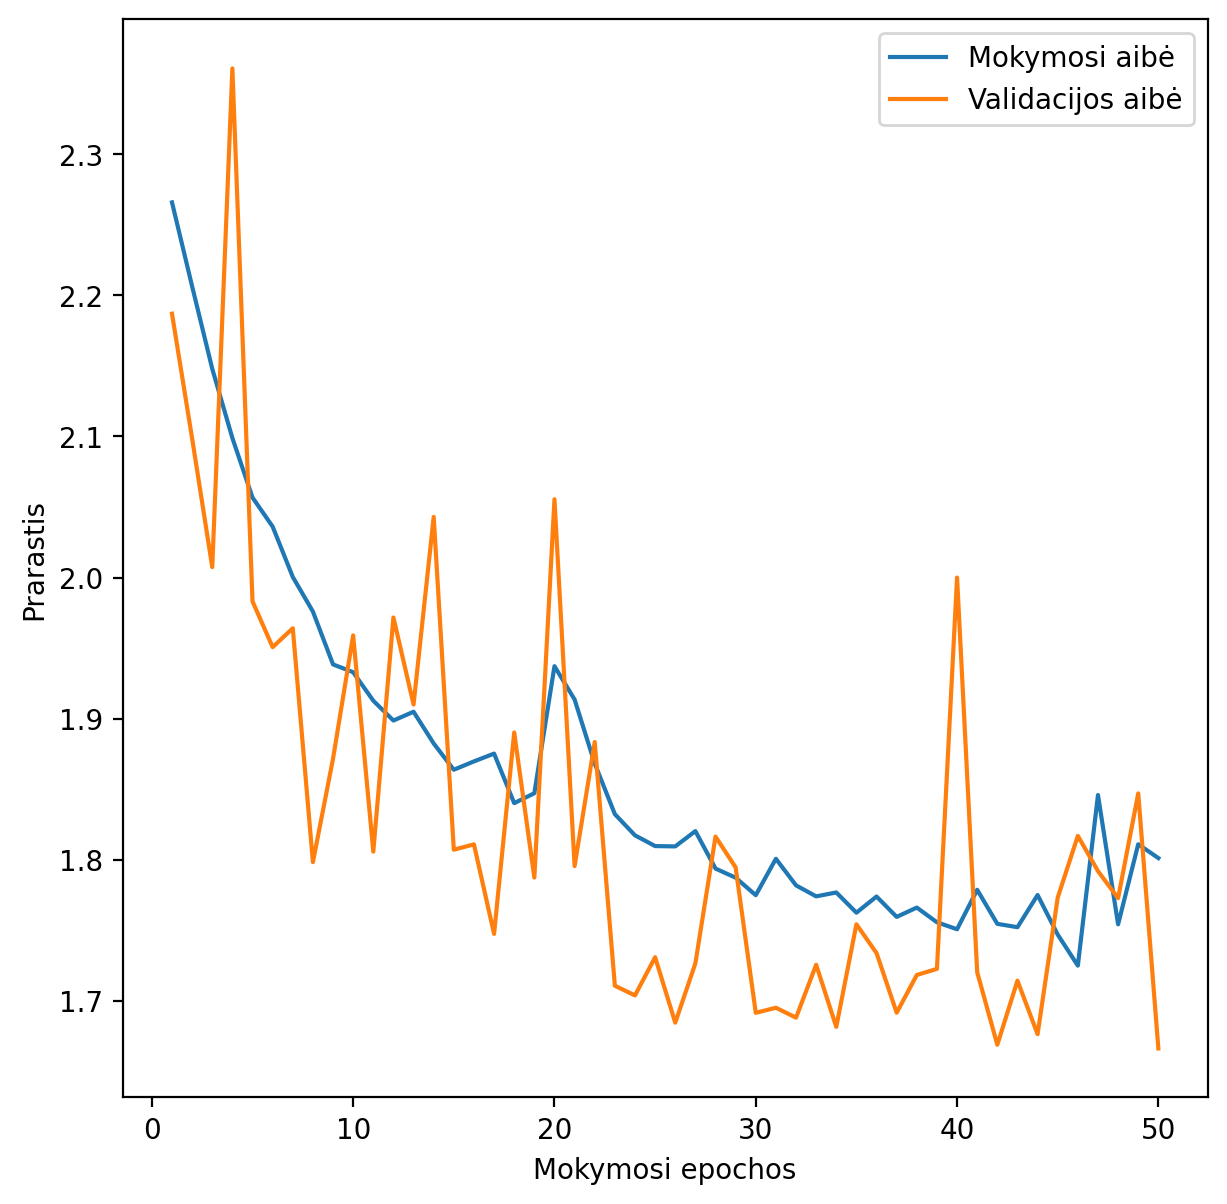

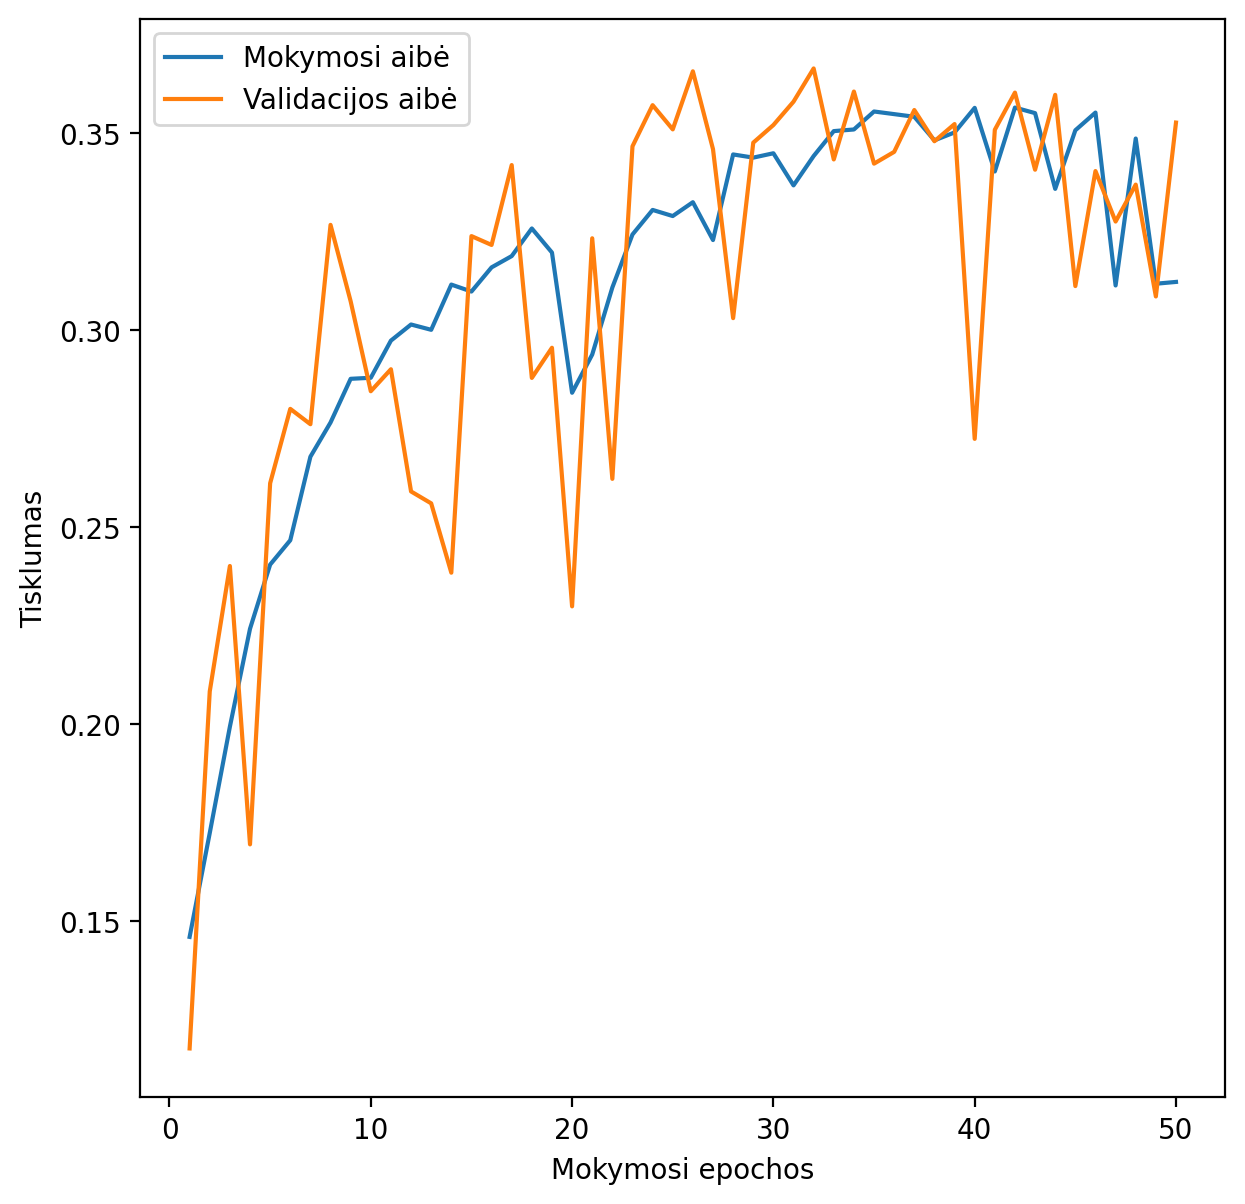

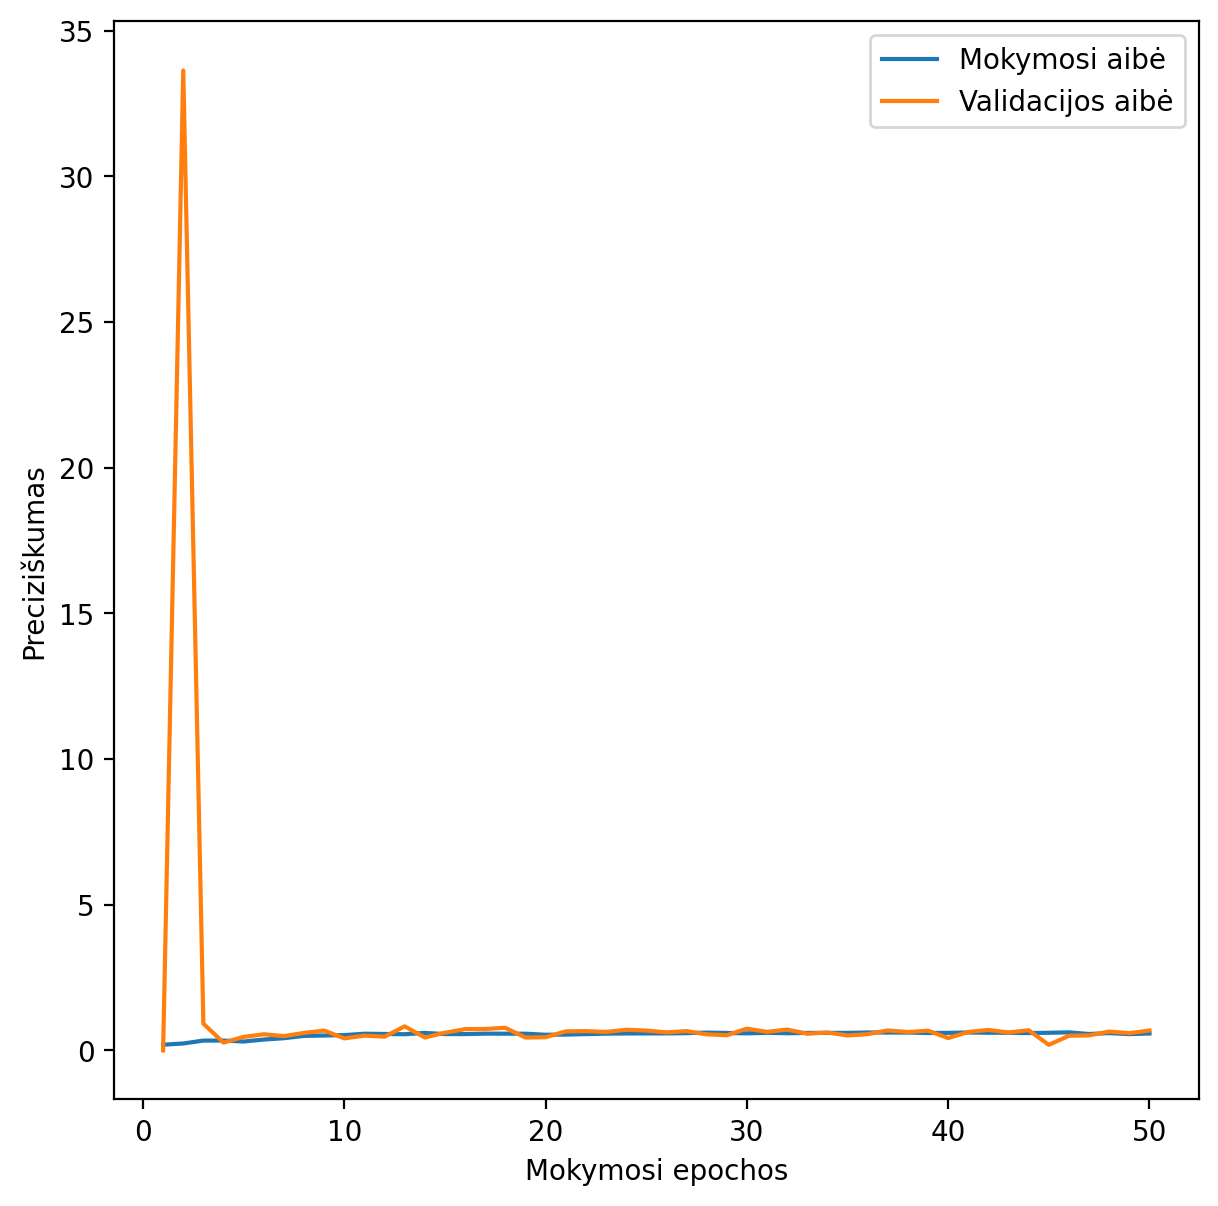

In [11]:
draw_res(res_model_w1, data_loc, "model_w1", DF_test)

In [12]:
#DF_train_scan = pd.read_csv(data_loc + data_name + "reduced_scan.csv")
DF_train_scan = DF_train
#run_setup = [[ELU, LeakyReLU], ['ELU', 'LeakyReLU'], [1.5, 1.5], [[5, X_width]]]
run_setup_ELU = [[ELU], ['ELU'], [0.5, 1, 1.5], [[5, X_width]]]
param_res_ELU, hist_res_ELU = scanner(data_loc + "scanner/", DF_train_scan, DF_test, 
                                      run_setup_ELU[0], run_setup_ELU[1], run_setup_ELU[2], run_setup_ELU[3], 
                                      legend_names, iterations=3)

ELU_0.5_size_5_48_iter_0
Epoch 1/40
6800/6800 - 17s - loss: 2.2388 - accuracy: 0.1608 - precision: -3.2949e-02 - val_loss: 2.1873 - val_accuracy: 0.1598 - val_precision: 0.0000e+00
Epoch 2/40
6800/6800 - 17s - loss: 2.1629 - accuracy: 0.1977 - precision: 0.3585 - val_loss: 2.1225 - val_accuracy: 0.1547 - val_precision: 0.4289
Epoch 3/40
6800/6800 - 17s - loss: 2.0743 - accuracy: 0.2374 - precision: 0.4929 - val_loss: 1.9282 - val_accuracy: 0.2679 - val_precision: 0.6212
Epoch 4/40
6800/6800 - 17s - loss: 1.9641 - accuracy: 0.2837 - precision: 0.6150 - val_loss: 1.7901 - val_accuracy: 0.3201 - val_precision: 0.8201
Epoch 5/40
6800/6800 - 17s - loss: 1.9439 - accuracy: 0.2902 - precision: 0.5983 - val_loss: 1.9747 - val_accuracy: 0.2426 - val_precision: 0.6941
Epoch 6/40
6800/6800 - 17s - loss: 1.8966 - accuracy: 0.3107 - precision: 0.6241 - val_loss: 1.8165 - val_accuracy: 0.3002 - val_precision: 0.6864
Epoch 7/40
6800/6800 - 16s - loss: 1.8643 - accuracy: 0.3112 - precision: 0.6208 - v

Epoch 16/40
6800/6800 - 17s - loss: 1.7829 - accuracy: 0.3466 - precision: 0.6455 - val_loss: 1.6675 - val_accuracy: 0.3636 - val_precision: 0.6536
Epoch 17/40
6800/6800 - 17s - loss: 1.7577 - accuracy: 0.3516 - precision: 0.6404 - val_loss: 1.8248 - val_accuracy: 0.2962 - val_precision: 0.5797
Epoch 18/40
6800/6800 - 17s - loss: 1.7530 - accuracy: 0.3545 - precision: 0.6348 - val_loss: 1.6845 - val_accuracy: 0.3534 - val_precision: 0.7413
Epoch 19/40
6800/6800 - 17s - loss: 1.7501 - accuracy: 0.3540 - precision: 0.6433 - val_loss: 1.7307 - val_accuracy: 0.3376 - val_precision: 0.5581
Epoch 20/40
6800/6800 - 17s - loss: 1.7574 - accuracy: 0.3496 - precision: 0.6192 - val_loss: 1.7849 - val_accuracy: 0.3218 - val_precision: 0.6354
Epoch 21/40
6800/6800 - 17s - loss: 1.7353 - accuracy: 0.3539 - precision: 0.6551 - val_loss: 1.7042 - val_accuracy: 0.3467 - val_precision: 0.6283
Epoch 22/40
6800/6800 - 17s - loss: 1.7518 - accuracy: 0.3475 - precision: 0.6294 - val_loss: 1.7349 - val_accur

Epoch 31/40
6800/6800 - 17s - loss: 1.8031 - accuracy: 0.3294 - precision: 0.6169 - val_loss: 1.7655 - val_accuracy: 0.3464 - val_precision: 0.6979
Epoch 32/40
6800/6800 - 16s - loss: 1.7956 - accuracy: 0.3300 - precision: 0.5974 - val_loss: 1.8882 - val_accuracy: 0.2875 - val_precision: 0.6790
Epoch 33/40
6800/6800 - 17s - loss: 1.7813 - accuracy: 0.3391 - precision: 0.6320 - val_loss: 1.7809 - val_accuracy: 0.3493 - val_precision: 0.6456
Epoch 34/40
6800/6800 - 17s - loss: 1.8273 - accuracy: 0.3240 - precision: 0.6142 - val_loss: 1.9629 - val_accuracy: 0.3170 - val_precision: 0.6158
Epoch 35/40
6800/6800 - 17s - loss: 1.7126 - accuracy: 0.3395 - precision: 0.6183 - val_loss: 1.7467 - val_accuracy: 0.3561 - val_precision: 0.6771
Epoch 36/40
6800/6800 - 17s - loss: 1.7466 - accuracy: 0.3308 - precision: 0.6154 - val_loss: 1.9586 - val_accuracy: 0.3125 - val_precision: 0.5601
Epoch 37/40
6800/6800 - 16s - loss: 1.8523 - accuracy: 0.3139 - precision: 0.6302 - val_loss: 1.9760 - val_accur

Epoch 5/40
6800/6800 - 13s - loss: 1.9354 - accuracy: 0.2950 - precision: 0.6202 - val_loss: 1.8792 - val_accuracy: 0.2936 - val_precision: 0.6778
Epoch 6/40
6800/6800 - 13s - loss: 1.9011 - accuracy: 0.3015 - precision: 0.6559 - val_loss: 1.7674 - val_accuracy: 0.3320 - val_precision: 0.7667
Epoch 7/40
6800/6800 - 13s - loss: 1.9027 - accuracy: 0.3017 - precision: 0.6599 - val_loss: 1.7660 - val_accuracy: 0.3224 - val_precision: 0.7921
Epoch 8/40
6800/6800 - 13s - loss: 1.8956 - accuracy: 0.3079 - precision: 0.6412 - val_loss: 2.0377 - val_accuracy: 0.2537 - val_precision: 0.5162
Epoch 9/40
6800/6800 - 13s - loss: 1.8938 - accuracy: 0.3043 - precision: 0.6467 - val_loss: 1.9114 - val_accuracy: 0.2606 - val_precision: 0.4420
Epoch 10/40
6800/6800 - 13s - loss: 1.8774 - accuracy: 0.3139 - precision: 0.6384 - val_loss: 1.9323 - val_accuracy: 0.2659 - val_precision: 0.5823
Epoch 11/40
6800/6800 - 13s - loss: 1.8605 - accuracy: 0.3173 - precision: 0.6318 - val_loss: 1.8385 - val_accuracy: 

Epoch 20/40
6800/6800 - 13s - loss: 1.7825 - accuracy: 0.3457 - precision: 0.6447 - val_loss: 1.6664 - val_accuracy: 0.3630 - val_precision: 0.6726
Epoch 21/40
6800/6800 - 13s - loss: 1.7881 - accuracy: 0.3346 - precision: 0.6488 - val_loss: 1.6939 - val_accuracy: 0.3537 - val_precision: 0.6392
Epoch 22/40
6800/6800 - 13s - loss: 1.7789 - accuracy: 0.3441 - precision: 0.6389 - val_loss: 1.7362 - val_accuracy: 0.3378 - val_precision: 0.6341
Epoch 23/40
6800/6800 - 13s - loss: 1.7540 - accuracy: 0.3495 - precision: 0.6389 - val_loss: 1.7630 - val_accuracy: 0.3289 - val_precision: 0.5669
Epoch 24/40
6800/6800 - 13s - loss: 1.7352 - accuracy: 0.3603 - precision: 0.6458 - val_loss: 1.6925 - val_accuracy: 0.3487 - val_precision: 0.6533
Epoch 25/40
6800/6800 - 13s - loss: 1.7429 - accuracy: 0.3567 - precision: 0.6458 - val_loss: 1.6874 - val_accuracy: 0.3559 - val_precision: 0.6635
Epoch 26/40
6800/6800 - 13s - loss: 1.7762 - accuracy: 0.3523 - precision: 0.6395 - val_loss: 2.0329 - val_accur

Epoch 35/40
6800/6800 - 17s - loss: 1.7086 - accuracy: 0.3621 - precision: 0.6426 - val_loss: 1.7815 - val_accuracy: 0.3390 - val_precision: 0.6285
Epoch 36/40
6800/6800 - 17s - loss: 1.7151 - accuracy: 0.3596 - precision: 0.6187 - val_loss: 1.7136 - val_accuracy: 0.3541 - val_precision: 0.6798
Epoch 37/40
6800/6800 - 17s - loss: 1.7011 - accuracy: 0.3651 - precision: 0.6305 - val_loss: 1.7204 - val_accuracy: 0.3593 - val_precision: 0.6826
Epoch 38/40
6800/6800 - 17s - loss: 1.6981 - accuracy: 0.3541 - precision: 0.6150 - val_loss: 1.9109 - val_accuracy: 0.3161 - val_precision: 0.5587
Epoch 39/40
6800/6800 - 16s - loss: 1.7294 - accuracy: 0.3532 - precision: 0.6046 - val_loss: 1.8235 - val_accuracy: 0.2988 - val_precision: 0.5494
Epoch 40/40
6800/6800 - 17s - loss: 1.6874 - accuracy: 0.3612 - precision: 0.6220 - val_loss: 1.8552 - val_accuracy: 0.3254 - val_precision: 0.6221
INFO:tensorflow:Assets written to: /home/dominykas/dy_mas_do/MuMu/scanner/ELU_1.5_size_5_48/iter0_last/assets
EL

Epoch 9/40
6800/6800 - 17s - loss: 1.9044 - accuracy: 0.3025 - precision: 0.6354 - val_loss: 1.7529 - val_accuracy: 0.3407 - val_precision: 0.7308
Epoch 10/40
6800/6800 - 17s - loss: 1.8827 - accuracy: 0.3124 - precision: 0.6324 - val_loss: 1.9270 - val_accuracy: 0.2691 - val_precision: 0.7188
Epoch 11/40
6800/6800 - 17s - loss: 1.8812 - accuracy: 0.3090 - precision: 0.6353 - val_loss: 1.8333 - val_accuracy: 0.2989 - val_precision: 0.6665
Epoch 12/40
6800/6800 - 17s - loss: 1.8397 - accuracy: 0.3297 - precision: 0.6627 - val_loss: 1.8007 - val_accuracy: 0.3198 - val_precision: 0.7086
Epoch 13/40
6800/6800 - 17s - loss: 1.8264 - accuracy: 0.3274 - precision: 0.6499 - val_loss: 1.7835 - val_accuracy: 0.3257 - val_precision: 0.6509
Epoch 14/40
6800/6800 - 17s - loss: 1.8294 - accuracy: 0.3268 - precision: 0.6390 - val_loss: 1.6974 - val_accuracy: 0.3504 - val_precision: 0.7001
Epoch 15/40
6800/6800 - 17s - loss: 1.8185 - accuracy: 0.3365 - precision: 0.6662 - val_loss: 1.7518 - val_accura

In [13]:
param_res_ELU

array([[[[0.70983462, 0.36843333],
         [0.70983462, 0.36843333],
         [0.23075961, 0.23853761]],

        [[0.69571991, 0.35351966],
         [0.69571991, 0.35351966],
         [0.52155998, 0.24679129]],

        [[0.70413427, 0.35138783],
         [0.70413427, 0.35138783],
         [0.49095954, 0.21141035]]],


       [[[0.72741676, 0.34802319],
         [0.72741676, 0.34802319],
         [0.00424146, 0.17286784]],

        [[0.68245287, 0.3459603 ],
         [0.65492873, 0.33567154],
         [0.00829335, 0.15391357]],

        [[0.71688914, 0.34761215],
         [0.71688914, 0.34761215],
         [0.2761403 , 0.2055692 ]]],


       [[[0.70470302, 0.34136278],
         [0.70011152, 0.34491684],
         [0.65400313, 0.33419107]],

        [[0.65067713, 0.35673402],
         [0.72973792, 0.35316116],
         [0.3290771 , 0.26839229]],

        [[0.70595192, 0.34547269],
         [0.66527699, 0.35823132],
         [0.63884505, 0.29769631]]]])

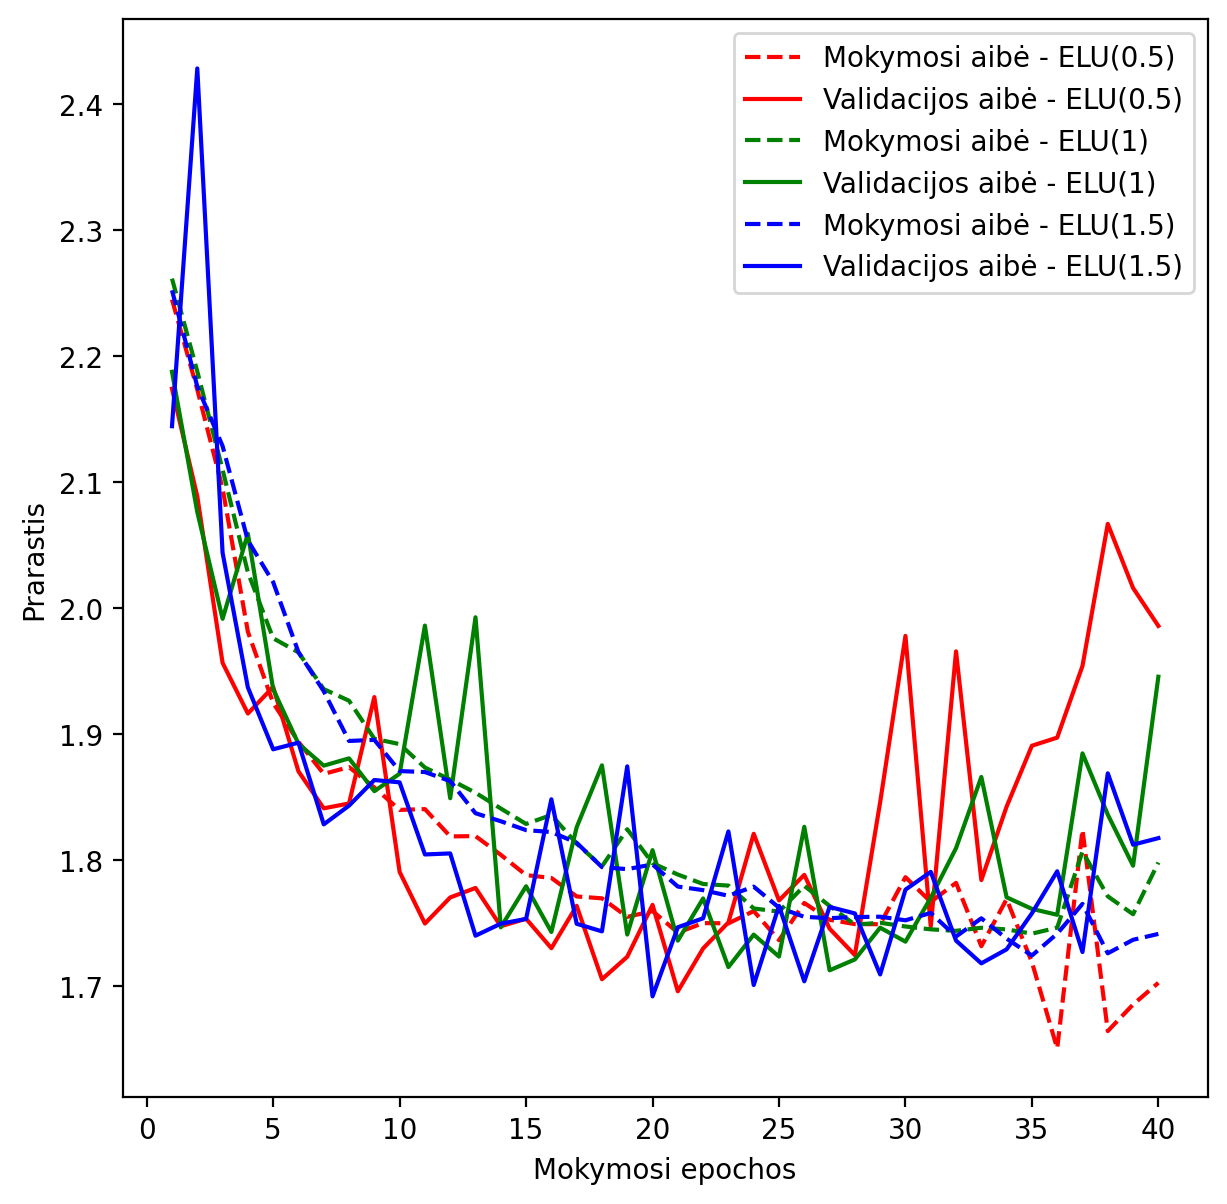

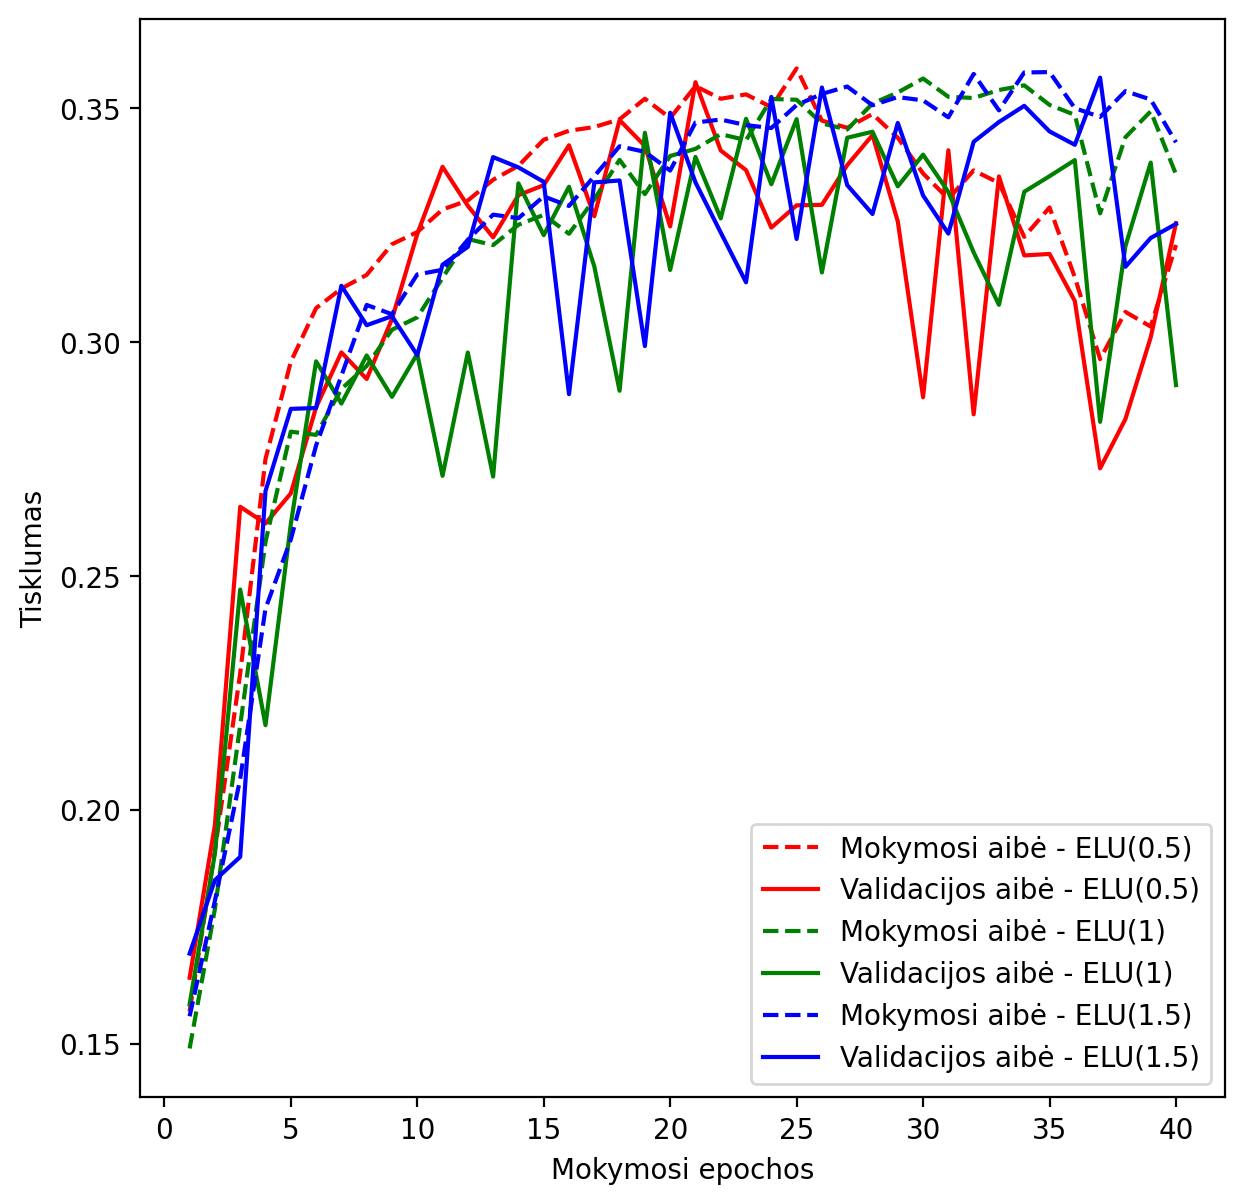

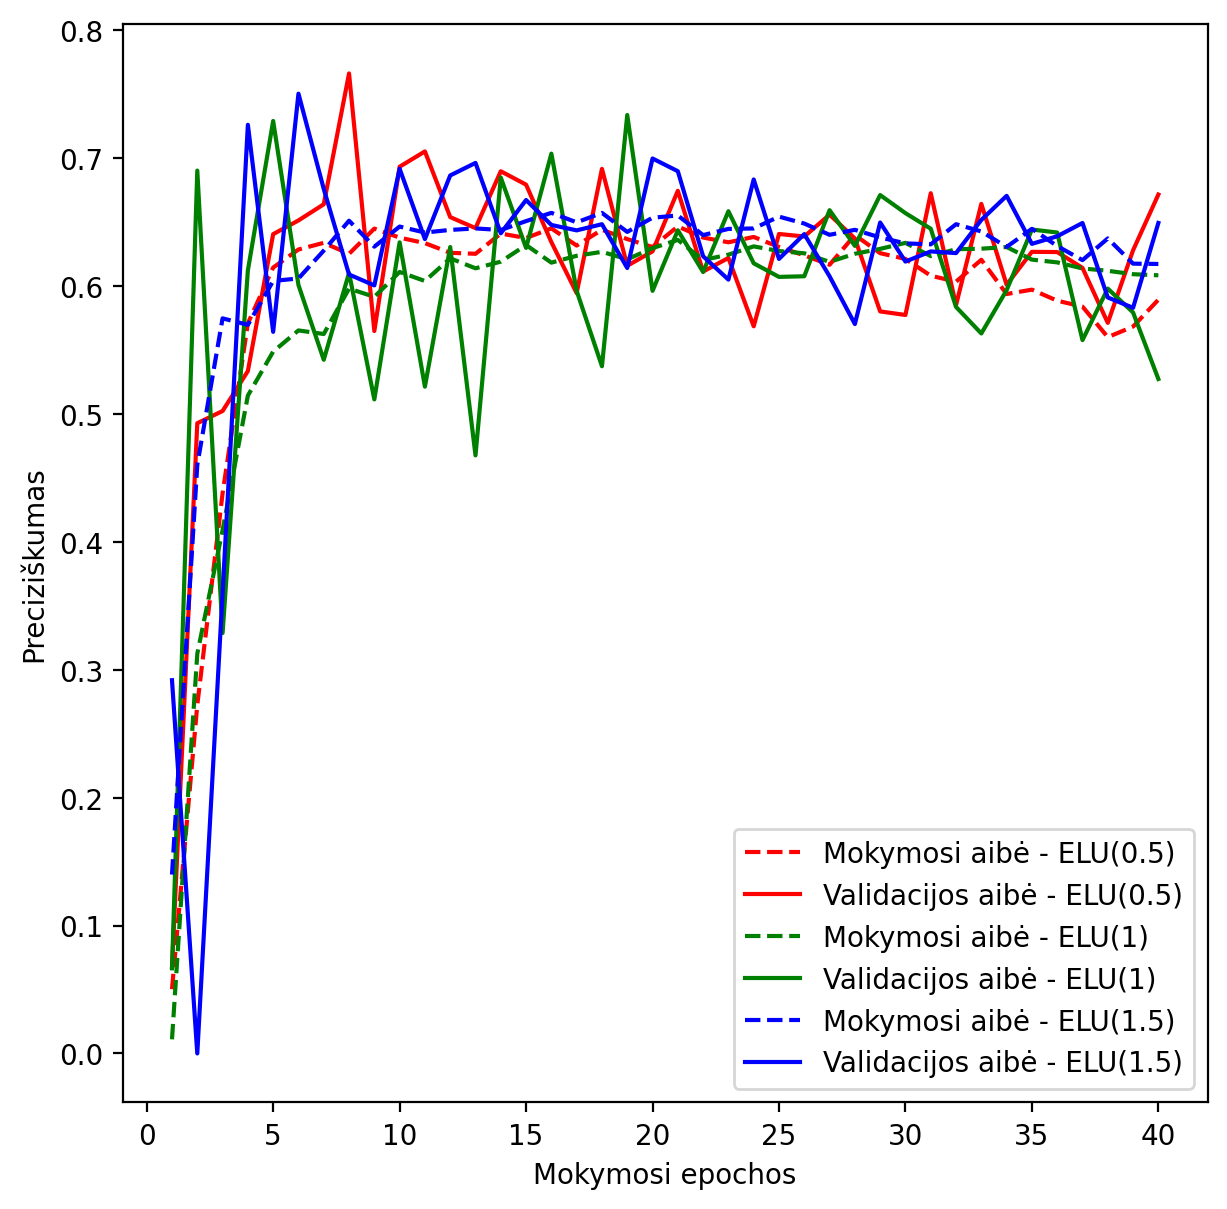

In [19]:
#hist_res = np.load(data_loc + "scanner/ELU_0.5_ELU_1_ELU_1.5_5_48.npy")
scanner_graph(data_loc + "scanner/", hist_res_ELU, run_setup_ELU[1], run_setup_ELU[2], run_setup_ELU[3])

In [23]:
run_setup_LeakyReLU = [[LeakyReLU], ['LeakyReLU'], [0.3, 0.5, 0.7], [[5, X_width]]]
param_res_LeakyReLU, hist_res_LeakyReLU = scanner(data_loc + "scanner/", DF_train_scan, DF_test, 
                                                  run_setup_LeakyReLU[0], run_setup_LeakyReLU[1], 
                                                  run_setup_LeakyReLU[2], run_setup_LeakyReLU[3], 
                                                  legend_names, iterations=3)

LeakyReLU_0.3_size_5_48_iter_0
Epoch 1/40
6800/6800 - 11s - loss: 2.2449 - accuracy: 0.1487 - precision: 0.0484 - val_loss: 2.1321 - val_accuracy: 0.1925 - val_precision: 0.5142
Epoch 2/40
6800/6800 - 11s - loss: 2.1528 - accuracy: 0.1978 - precision: 0.5777 - val_loss: 2.0954 - val_accuracy: 0.1960 - val_precision: 0.4231
Epoch 3/40
6800/6800 - 11s - loss: 2.0575 - accuracy: 0.2469 - precision: 0.6335 - val_loss: 1.9558 - val_accuracy: 0.2621 - val_precision: 0.4839
Epoch 4/40
6800/6800 - 11s - loss: 1.9543 - accuracy: 0.2864 - precision: 0.6363 - val_loss: 2.2819 - val_accuracy: 0.2207 - val_precision: 0.2801
Epoch 5/40
6800/6800 - 11s - loss: 1.8996 - accuracy: 0.3081 - precision: 0.6505 - val_loss: 1.7864 - val_accuracy: 0.3200 - val_precision: 0.7481
Epoch 6/40
6800/6800 - 12s - loss: 1.8919 - accuracy: 0.3026 - precision: 0.6411 - val_loss: 1.7950 - val_accuracy: 0.3167 - val_precision: 0.8526
Epoch 7/40
6800/6800 - 12s - loss: 1.8682 - accuracy: 0.3161 - precision: 0.6397 - val_

Epoch 16/40
6800/6800 - 8s - loss: 1.7646 - accuracy: 0.3476 - precision: 0.6482 - val_loss: 1.7568 - val_accuracy: 0.3313 - val_precision: 0.6511
Epoch 17/40
6800/6800 - 8s - loss: 1.7450 - accuracy: 0.3580 - precision: 0.6507 - val_loss: 1.7049 - val_accuracy: 0.3477 - val_precision: 0.6391
Epoch 18/40
6800/6800 - 9s - loss: 1.7430 - accuracy: 0.3604 - precision: 0.6438 - val_loss: 1.9385 - val_accuracy: 0.2806 - val_precision: 0.5563
Epoch 19/40
6800/6800 - 8s - loss: 1.7463 - accuracy: 0.3595 - precision: 0.6304 - val_loss: 1.6615 - val_accuracy: 0.3643 - val_precision: 0.7145
Epoch 20/40
6800/6800 - 8s - loss: 1.7413 - accuracy: 0.3583 - precision: 0.6268 - val_loss: 1.9624 - val_accuracy: 0.3019 - val_precision: 0.4429
Epoch 21/40
6800/6800 - 8s - loss: 1.7316 - accuracy: 0.3591 - precision: 0.6452 - val_loss: 1.6940 - val_accuracy: 0.3477 - val_precision: 0.6835
Epoch 22/40
6800/6800 - 8s - loss: 1.7324 - accuracy: 0.3615 - precision: 0.6482 - val_loss: 1.7156 - val_accuracy: 0.

Epoch 31/40
6800/6800 - 8s - loss: 1.6997 - accuracy: 0.3609 - precision: 0.6203 - val_loss: 1.8406 - val_accuracy: 0.3269 - val_precision: 0.5975
Epoch 32/40
6800/6800 - 8s - loss: 1.7026 - accuracy: 0.3558 - precision: 0.6180 - val_loss: 1.7778 - val_accuracy: 0.3337 - val_precision: 0.5930
Epoch 33/40
6800/6800 - 9s - loss: 1.7170 - accuracy: 0.3509 - precision: 0.6132 - val_loss: 1.7703 - val_accuracy: 0.3318 - val_precision: 0.5724
Epoch 34/40
6800/6800 - 8s - loss: 1.6847 - accuracy: 0.3550 - precision: 0.6175 - val_loss: 1.7566 - val_accuracy: 0.3470 - val_precision: 0.6024
Epoch 35/40
6800/6800 - 8s - loss: 1.6566 - accuracy: 0.3518 - precision: 0.6085 - val_loss: 1.8260 - val_accuracy: 0.3555 - val_precision: 0.6341
Epoch 36/40
6800/6800 - 8s - loss: 1.6702 - accuracy: 0.3430 - precision: 0.5818 - val_loss: 2.0149 - val_accuracy: 0.2583 - val_precision: 0.5248
Epoch 37/40
6800/6800 - 8s - loss: 1.7184 - accuracy: 0.3297 - precision: 0.5547 - val_loss: 1.9901 - val_accuracy: 0.

Epoch 5/40
6800/6800 - 8s - loss: 1.9348 - accuracy: 0.2908 - precision: 0.6209 - val_loss: 1.8006 - val_accuracy: 0.3321 - val_precision: 0.7492
Epoch 6/40
6800/6800 - 8s - loss: 1.8991 - accuracy: 0.3072 - precision: 0.6314 - val_loss: 1.8921 - val_accuracy: 0.2875 - val_precision: 0.5461
Epoch 7/40
6800/6800 - 8s - loss: 1.8728 - accuracy: 0.3111 - precision: 0.6408 - val_loss: 2.1525 - val_accuracy: 0.2198 - val_precision: 0.2296
Epoch 8/40
6800/6800 - 8s - loss: 1.8558 - accuracy: 0.3209 - precision: 0.6564 - val_loss: 1.7922 - val_accuracy: 0.3214 - val_precision: 0.6565
Epoch 9/40
6800/6800 - 8s - loss: 1.8544 - accuracy: 0.3208 - precision: 0.6632 - val_loss: 1.9944 - val_accuracy: 0.2697 - val_precision: 0.5271
Epoch 10/40
6800/6800 - 8s - loss: 1.8367 - accuracy: 0.3250 - precision: 0.6268 - val_loss: 1.7138 - val_accuracy: 0.3509 - val_precision: 0.6887
Epoch 11/40
6800/6800 - 8s - loss: 1.8181 - accuracy: 0.3352 - precision: 0.6427 - val_loss: 1.7378 - val_accuracy: 0.3429 

Epoch 20/40
6800/6800 - 9s - loss: 1.7720 - accuracy: 0.3433 - precision: 0.6555 - val_loss: 1.7157 - val_accuracy: 0.3517 - val_precision: 0.6987
Epoch 21/40
6800/6800 - 9s - loss: 1.7512 - accuracy: 0.3588 - precision: 0.6413 - val_loss: 1.6697 - val_accuracy: 0.3652 - val_precision: 0.6706
Epoch 22/40
6800/6800 - 9s - loss: 1.7528 - accuracy: 0.3551 - precision: 0.6393 - val_loss: 1.7231 - val_accuracy: 0.3415 - val_precision: 0.7220
Epoch 23/40
6800/6800 - 9s - loss: 1.7378 - accuracy: 0.3629 - precision: 0.6525 - val_loss: 1.8893 - val_accuracy: 0.2995 - val_precision: 0.5529
Epoch 24/40
6800/6800 - 9s - loss: 1.7556 - accuracy: 0.3519 - precision: 0.6284 - val_loss: 1.6932 - val_accuracy: 0.3534 - val_precision: 0.6608
Epoch 25/40
6800/6800 - 9s - loss: 1.7554 - accuracy: 0.3536 - precision: 0.6412 - val_loss: 1.7108 - val_accuracy: 0.3502 - val_precision: 0.6203
Epoch 26/40
6800/6800 - 8s - loss: 1.7399 - accuracy: 0.3596 - precision: 0.6313 - val_loss: 1.6784 - val_accuracy: 0.

Epoch 35/40
6800/6800 - 8s - loss: 1.8213 - accuracy: 0.3303 - precision: 0.5921 - val_loss: 1.7032 - val_accuracy: 0.3553 - val_precision: 0.7333
Epoch 36/40
6800/6800 - 9s - loss: 1.7731 - accuracy: 0.3461 - precision: 0.6180 - val_loss: 1.7937 - val_accuracy: 0.3263 - val_precision: 0.5949
Epoch 37/40
6800/6800 - 9s - loss: 1.7737 - accuracy: 0.3443 - precision: 0.6214 - val_loss: 1.7890 - val_accuracy: 0.3293 - val_precision: 0.5608
Epoch 38/40
6800/6800 - 9s - loss: 1.7720 - accuracy: 0.3509 - precision: 0.6005 - val_loss: 1.7466 - val_accuracy: 0.3419 - val_precision: 0.5826
Epoch 39/40
6800/6800 - 8s - loss: 1.7690 - accuracy: 0.3467 - precision: 0.6133 - val_loss: 1.7187 - val_accuracy: 0.3522 - val_precision: 0.6614
Epoch 40/40
6800/6800 - 8s - loss: 1.7703 - accuracy: 0.3502 - precision: 0.6046 - val_loss: 1.7082 - val_accuracy: 0.3603 - val_precision: 0.7377
INFO:tensorflow:Assets written to: /home/dominykas/dy_mas_do/MuMu/scanner/LeakyReLU_0.7_size_5_48/iter0_last/assets
Le

Epoch 9/40
6800/6800 - 8s - loss: 1.9217 - accuracy: 0.2991 - precision: 0.4912 - val_loss: 1.9324 - val_accuracy: 0.2738 - val_precision: 0.3226
Epoch 10/40
6800/6800 - 10s - loss: 1.9001 - accuracy: 0.3007 - precision: 0.5330 - val_loss: 2.1536 - val_accuracy: 0.1839 - val_precision: 0.2237
Epoch 11/40
6800/6800 - 9s - loss: 1.8936 - accuracy: 0.3091 - precision: 0.5210 - val_loss: 1.8724 - val_accuracy: 0.3022 - val_precision: 0.7419
Epoch 12/40
6800/6800 - 8s - loss: 1.8830 - accuracy: 0.3035 - precision: 0.5542 - val_loss: 1.7856 - val_accuracy: 0.3413 - val_precision: 0.5883
Epoch 13/40
6800/6800 - 8s - loss: 1.8734 - accuracy: 0.3147 - precision: 0.5446 - val_loss: 1.9672 - val_accuracy: 0.2595 - val_precision: 0.3748
Epoch 14/40
6800/6800 - 9s - loss: 1.8676 - accuracy: 0.3136 - precision: 0.5613 - val_loss: 1.7788 - val_accuracy: 0.3270 - val_precision: 0.6440
Epoch 15/40
6800/6800 - 9s - loss: 1.8569 - accuracy: 0.3210 - precision: 0.5506 - val_loss: 2.2258 - val_accuracy: 0.

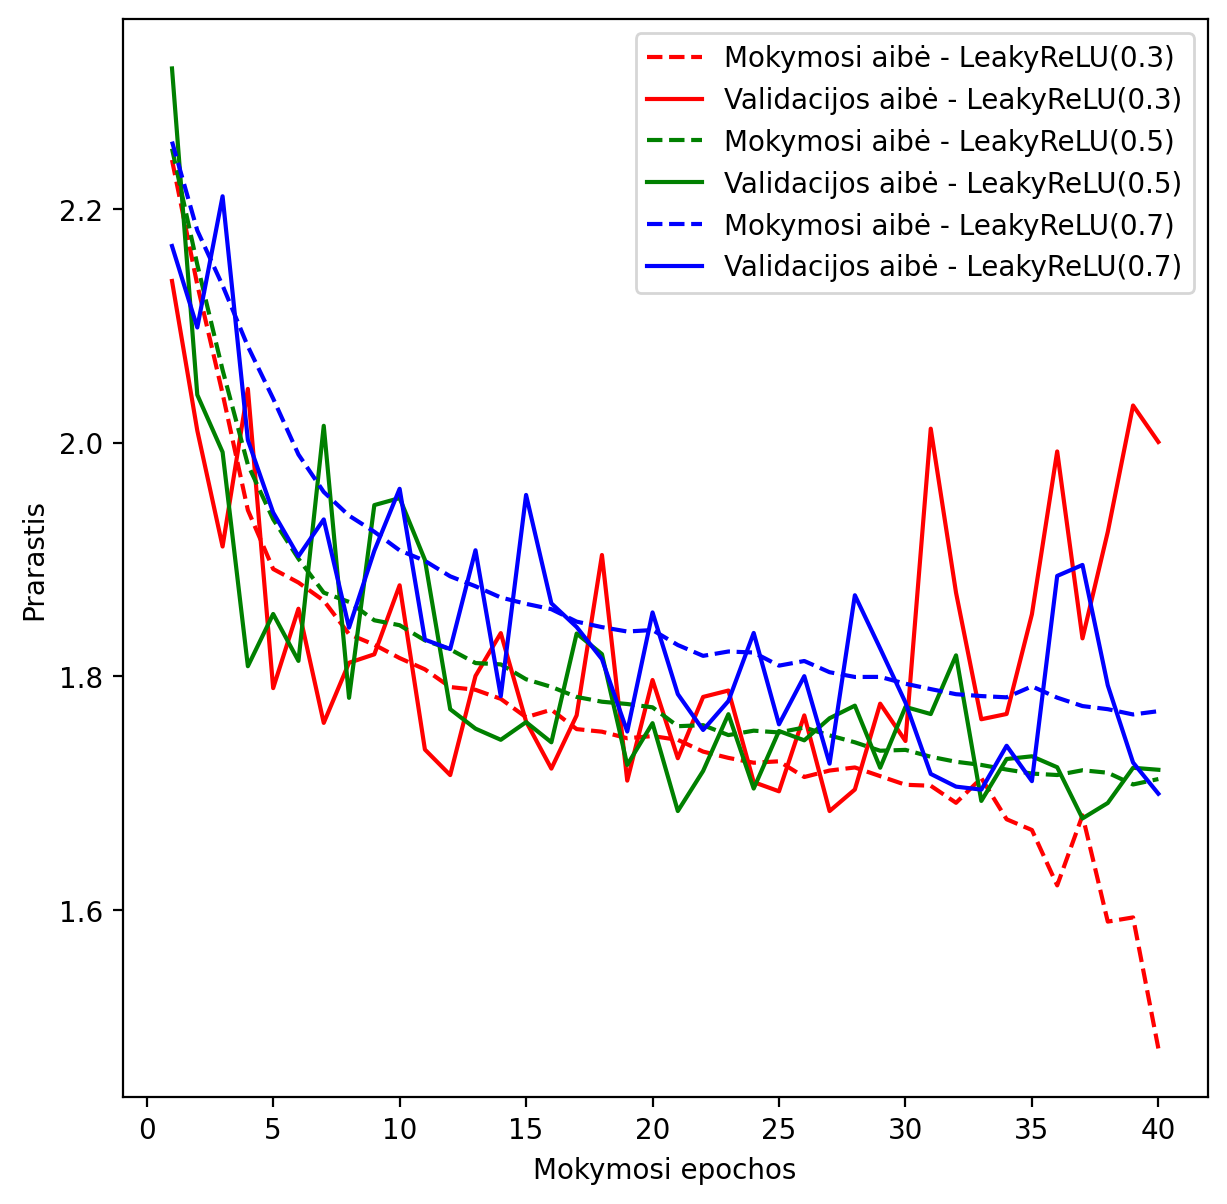

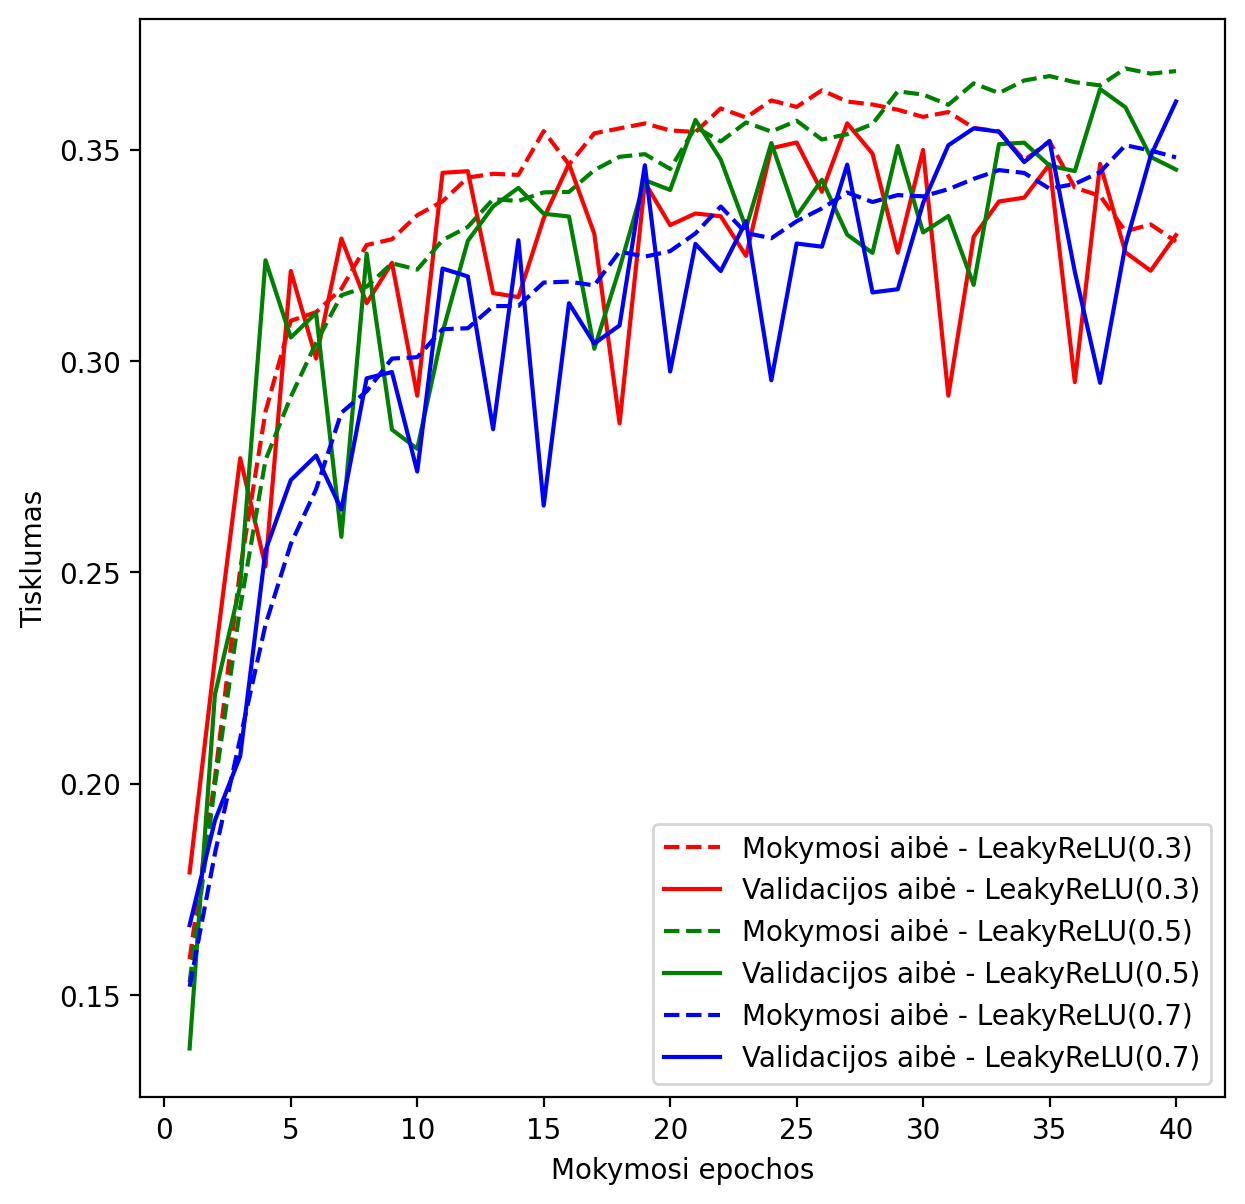

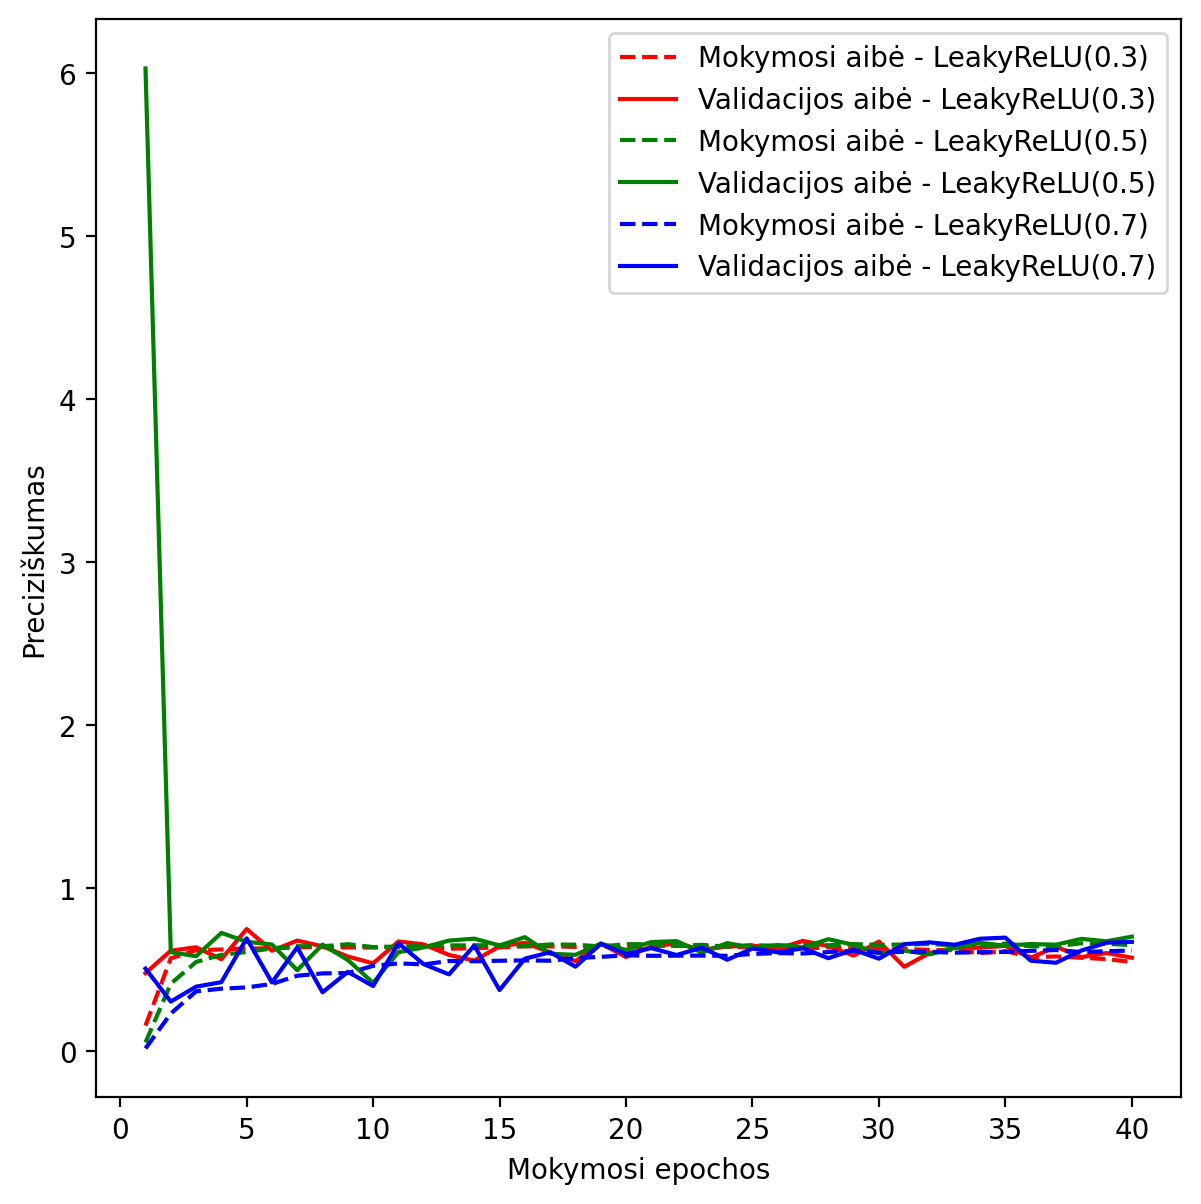

In [24]:
scanner_graph(data_loc + "scanner/", hist_res_LeakyReLU, 
              run_setup_LeakyReLU[1], run_setup_LeakyReLU[2], run_setup_LeakyReLU[3])

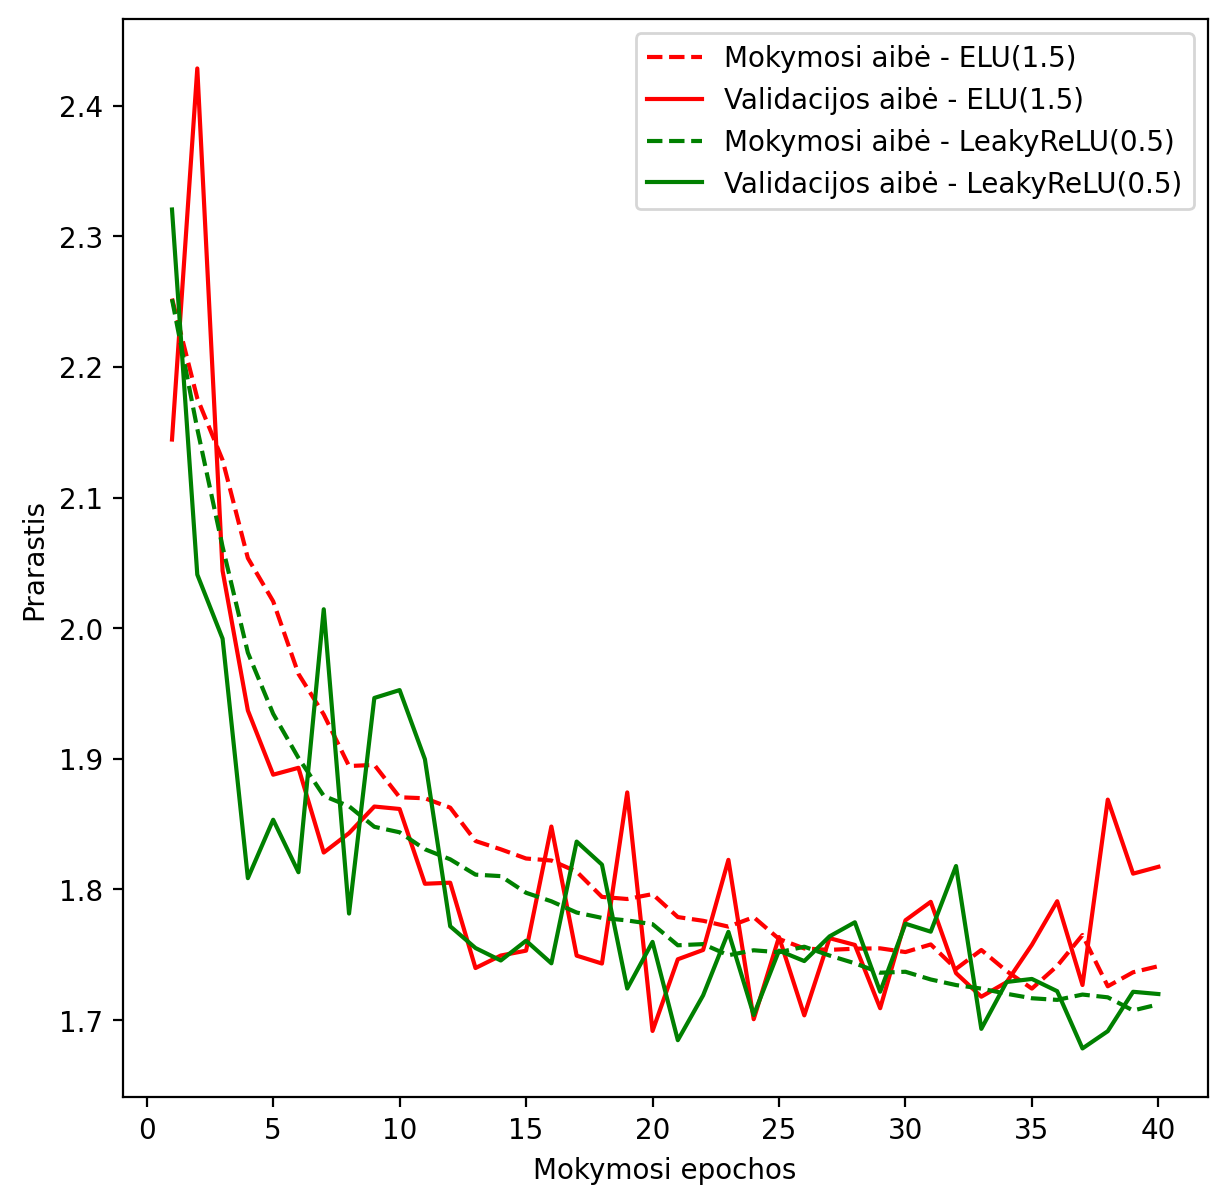

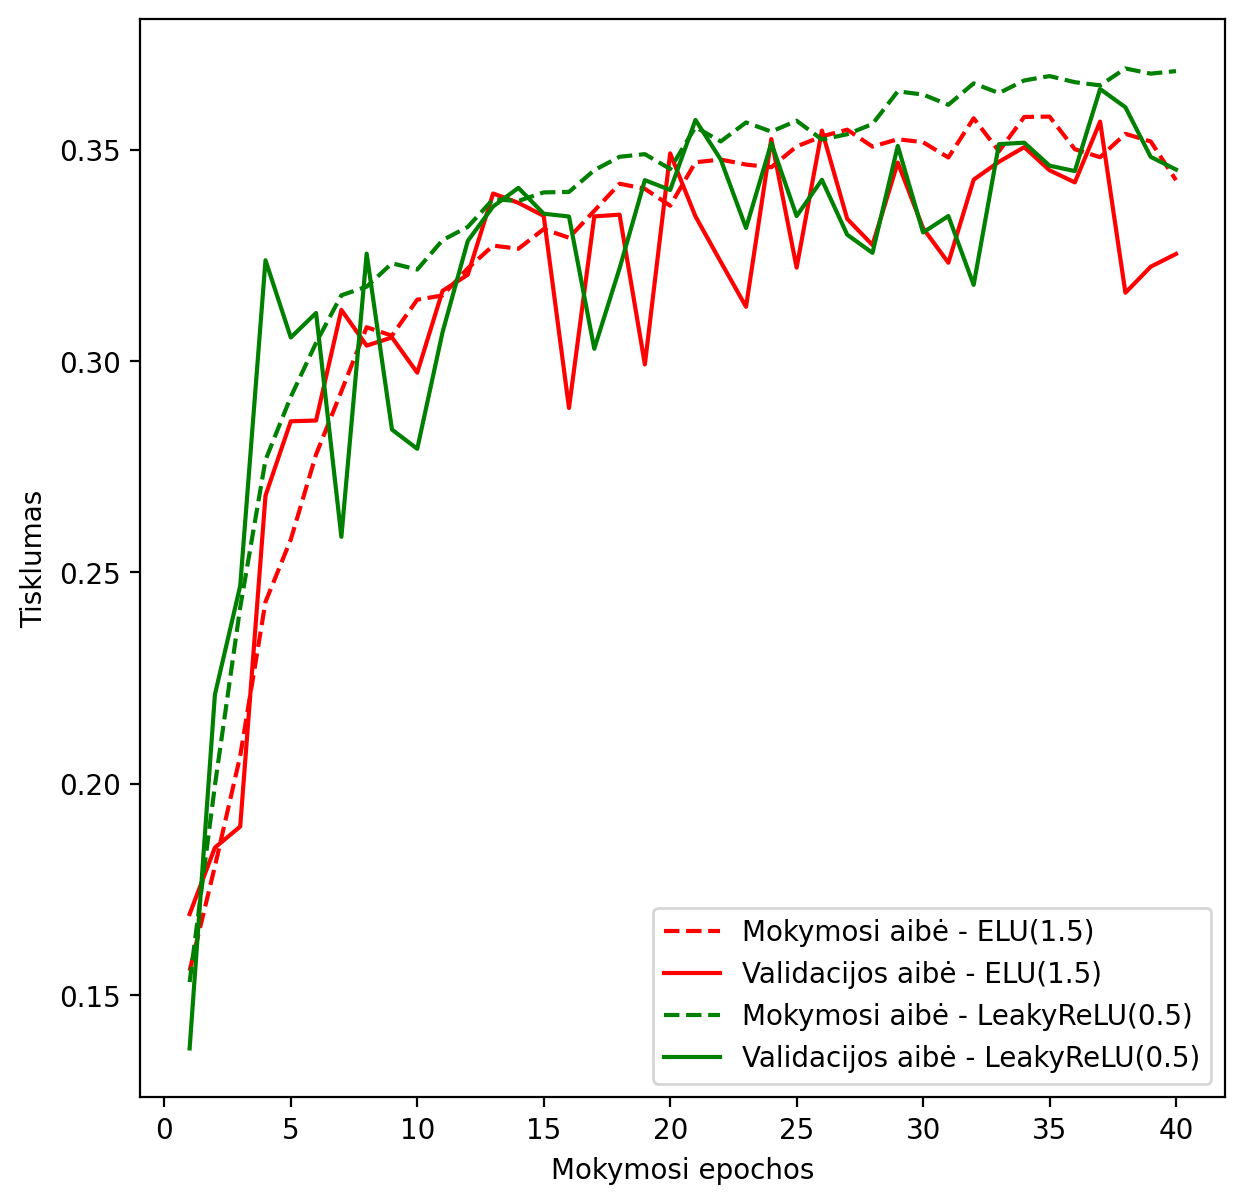

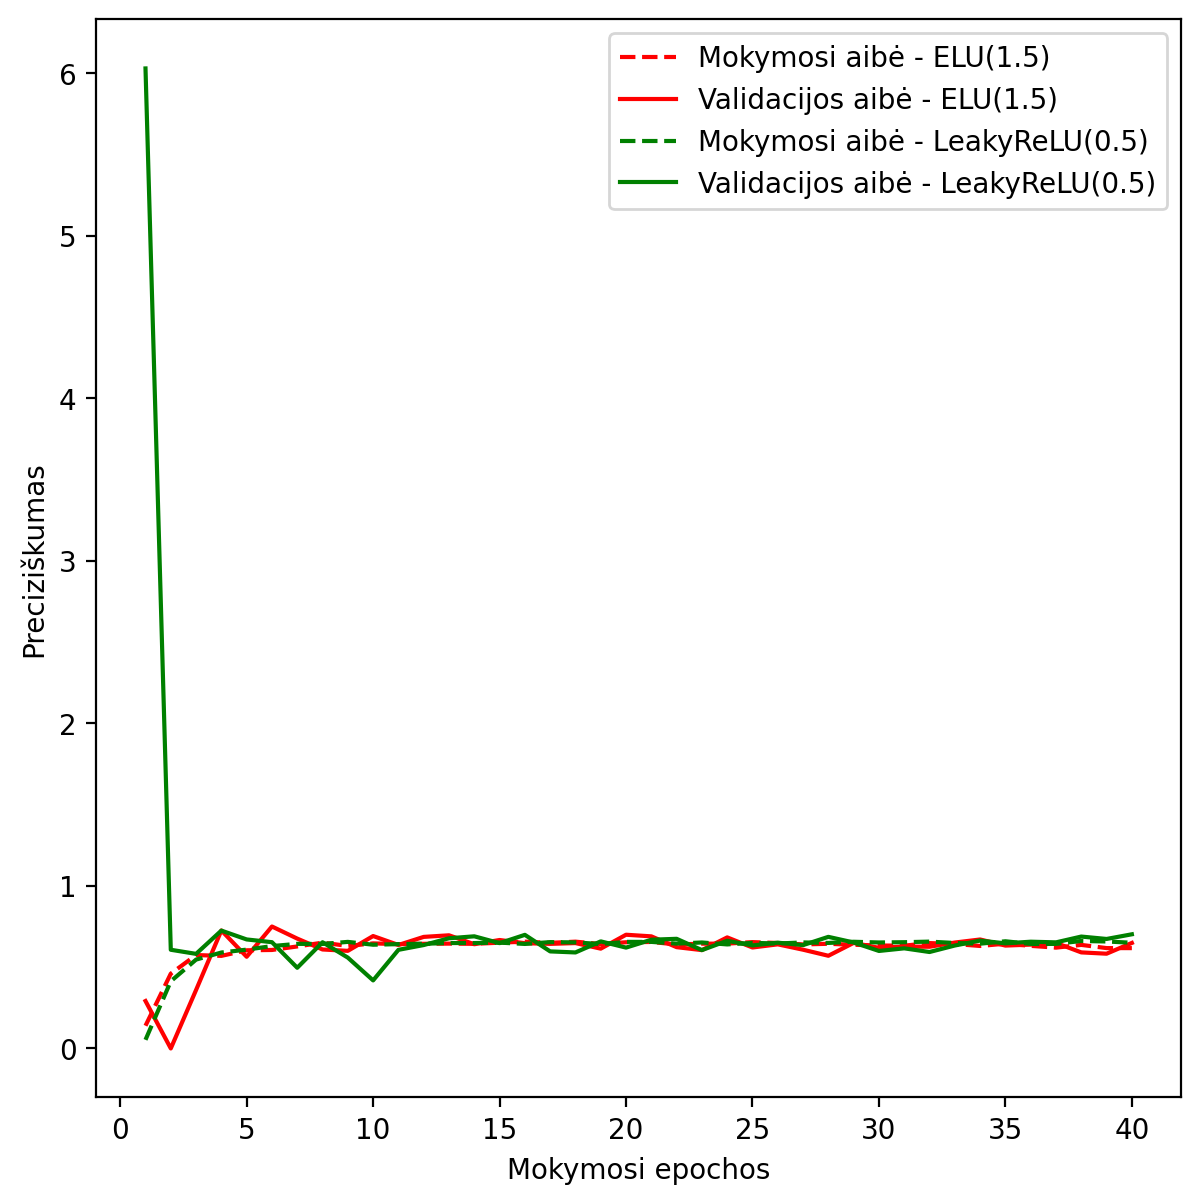

In [26]:
run_setup_mixed = [[ELU, LeakyReLU], ['ELU', 'LeakyReLU'], [1.5, 0.5], [[5, X_width]]]
hist_res_ELU = np.load(data_loc + "scanner/ELU_0.5_ELU_1_ELU_1.5_5_48.npy")
hist_res_LeakyReLU = np.load(data_loc + "scanner/LeakyReLU_0.3_LeakyReLU_0.5_LeakyReLU_0.7_5_48.npy")
scanner_graph(data_loc + "scanner/", np.array([hist_res_ELU[2], hist_res_LeakyReLU[1]]), 
              run_setup_mixed[1], run_setup_mixed[2], run_setup_mixed[3])

In [ ]:
run_setup = [[ELU], ['ELU'], [1], [[3, X_width], [5, X_width], [7, X_width]]]
param_res, hist_res = scanner(data_loc + "scanner/", DF_train_scan, DF_test, 
                              run_setup[0], run_setup[1], run_setup[2], run_setup[3], 
                              legend_names, iterations=3)

In [ ]:
scanner_graph(data_loc + "scanner/", hist_res, run_setup[1], run_setup[2], run_setup[3])

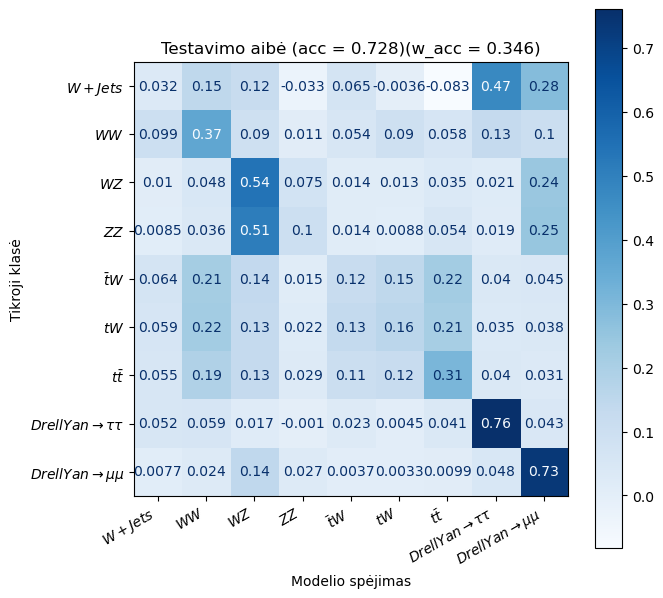

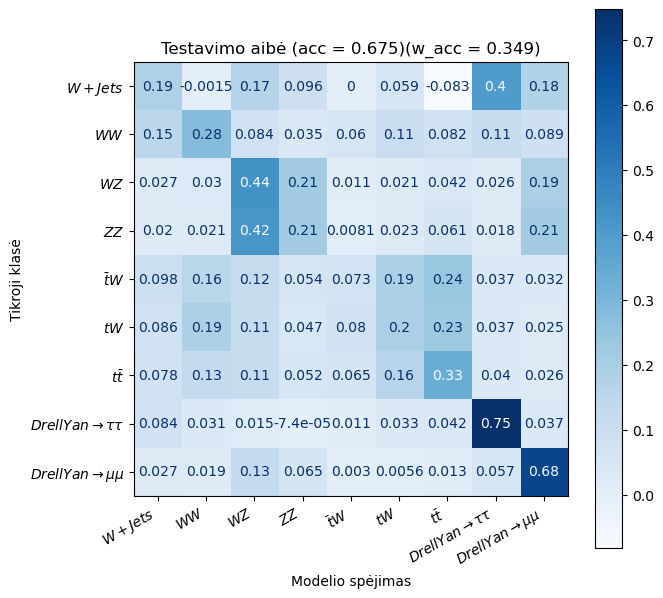

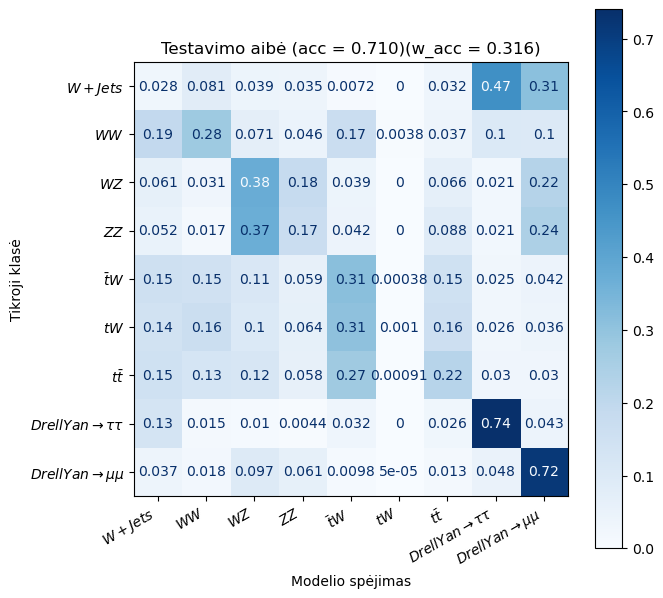

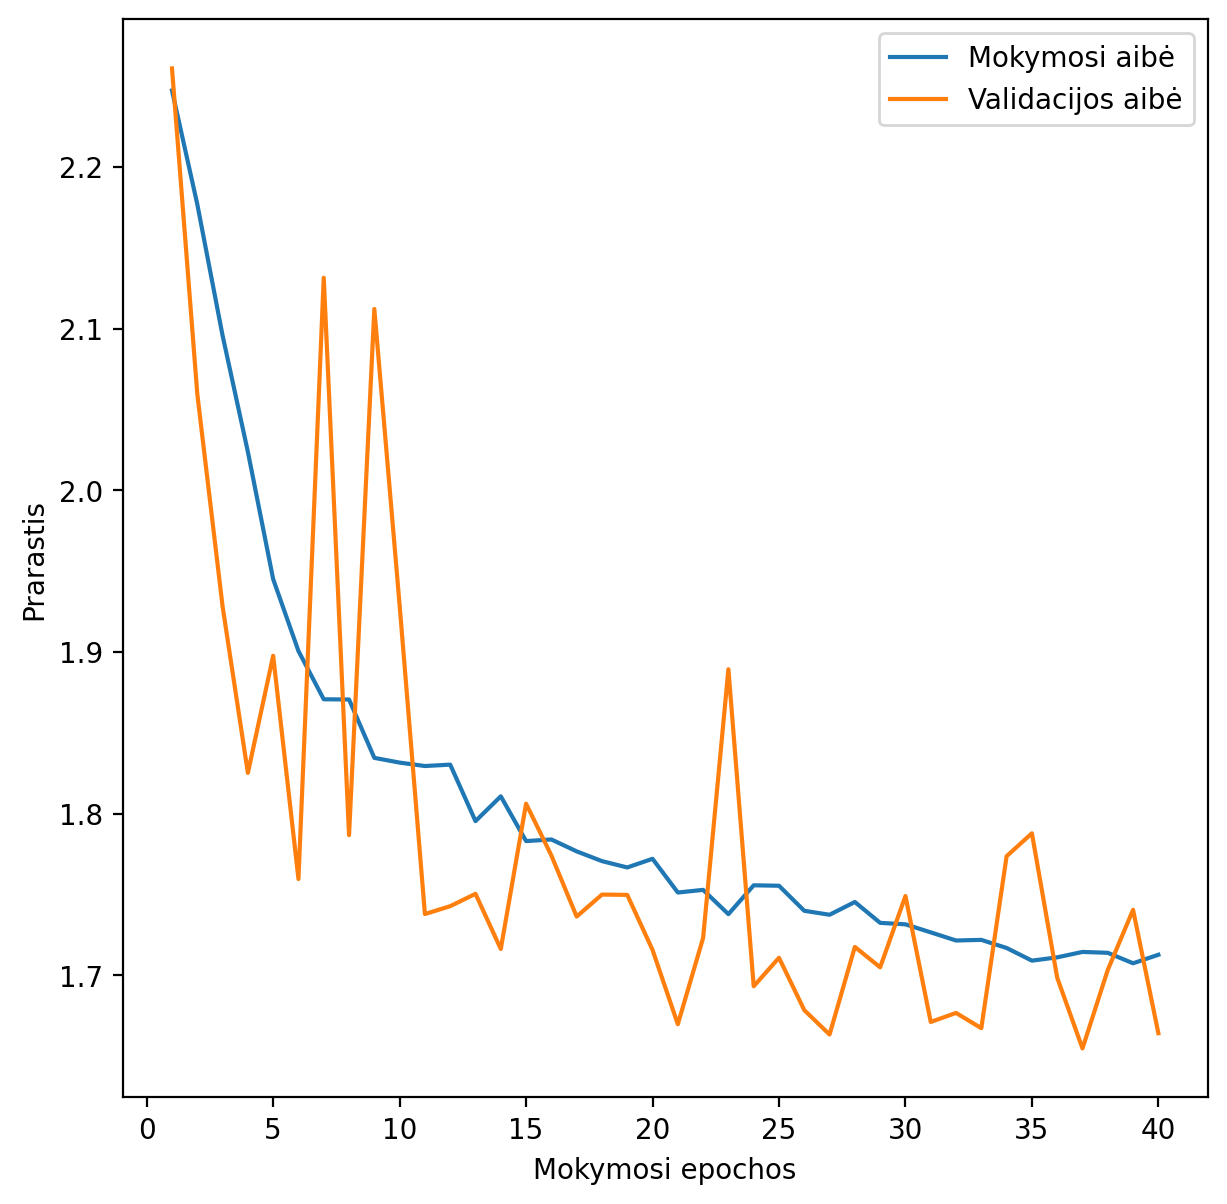

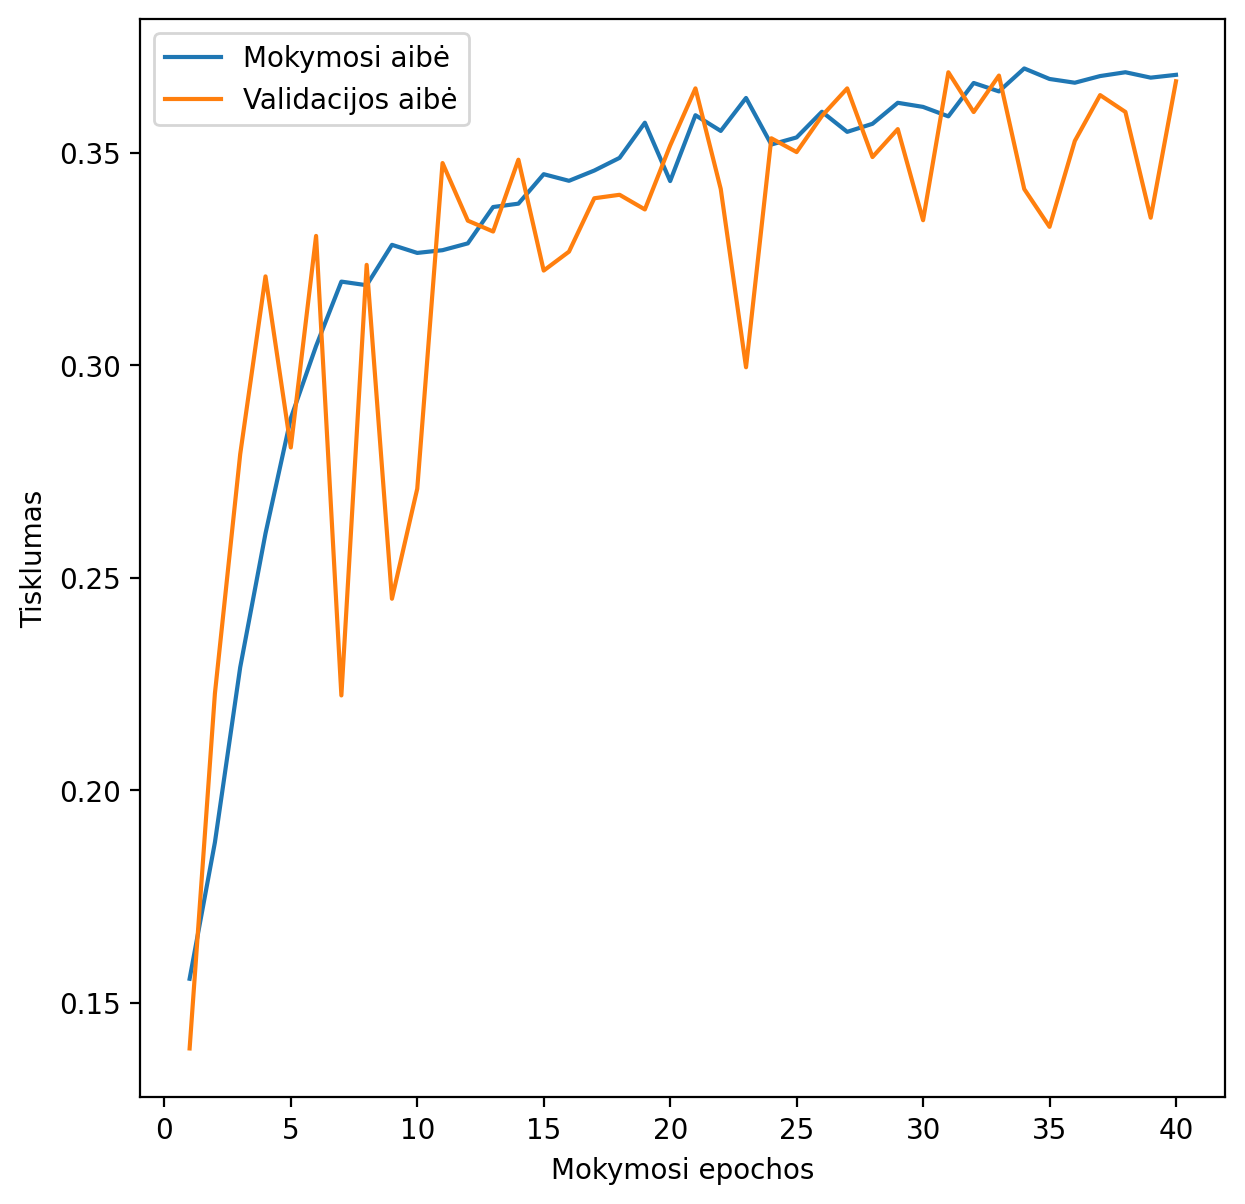

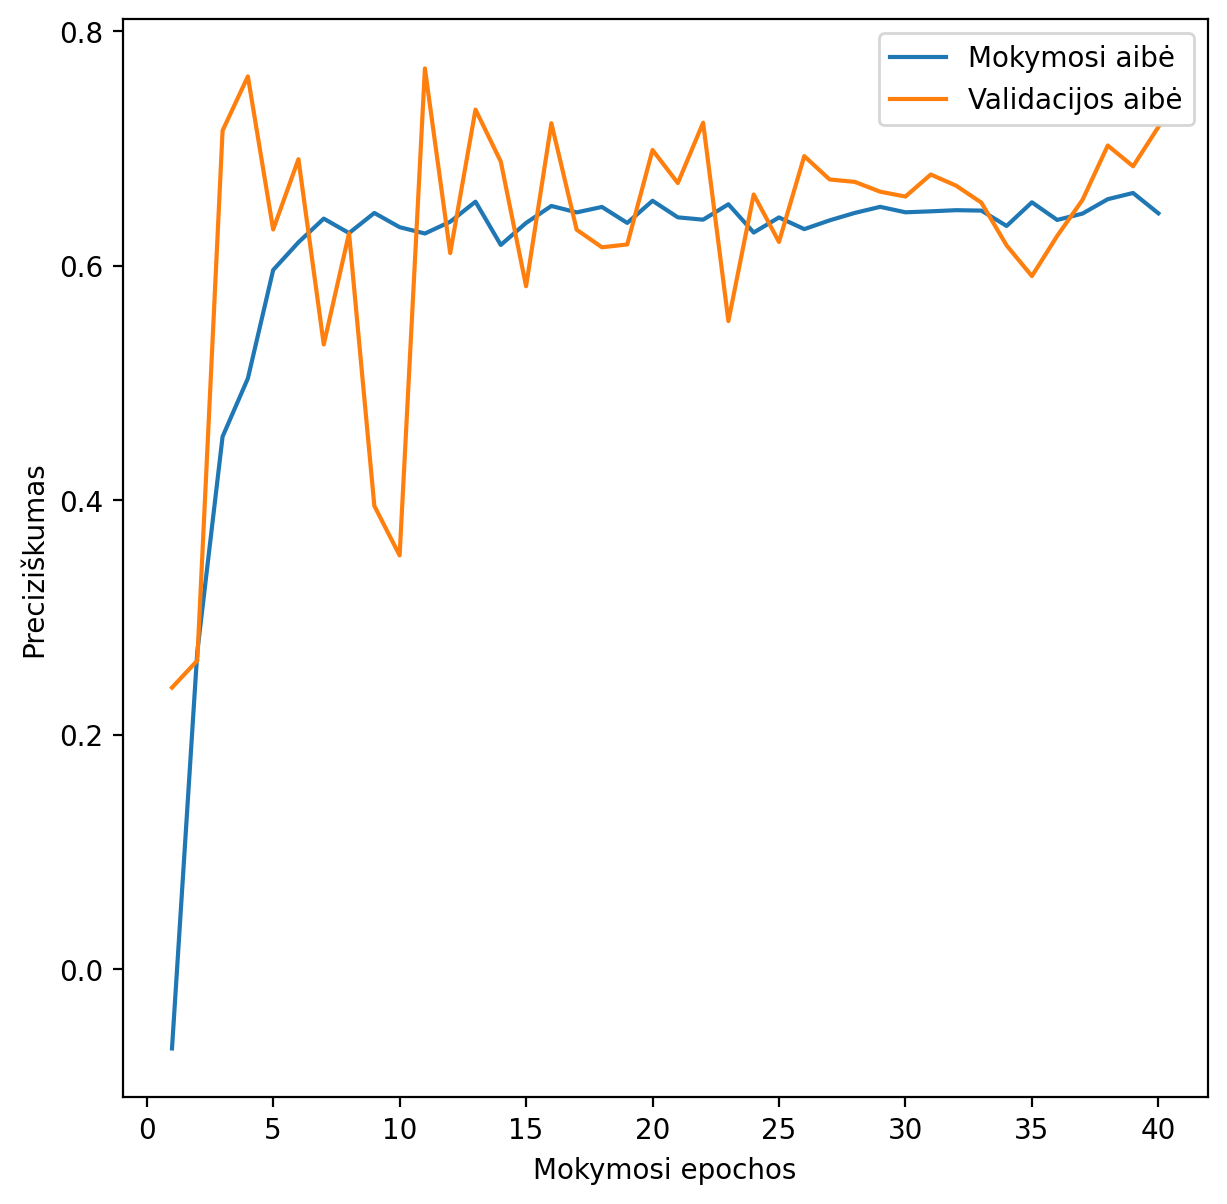

In [30]:
model_s = load_model(data_loc + "/scanner/LeakyReLU_0.5_size_5_48/iter2_last")
res_model_s = [model_s, *hist_res_LeakyReLU[1, 2]]
draw_res(res_model_s, data_loc + "/scanner/LeakyReLU_0.5_size_5_48/", "iter2", DF_test)